In [1]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import optuna
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, StackingRegressor, GradientBoostingRegressor
from tqdm import tqdm
import numpy as np
import joblib
import seaborn as sns
import os
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.optimize import minimize
import seaborn as sns
import optuna.visualization.matplotlib as optuna_vis
from sklearn.decomposition import PCA
from sklearn.svm import SVR

/Users/macbook/Desktop/DS304_perfume_investigation/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('window_slidding_data/all_kols_combined.csv')

In [3]:
import numpy
print(numpy.__version__)


2.2.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 65 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   kol_username                       463 non-null    object 
 1   month_start                        463 non-null    int64  
 2   year_start                         463 non-null    int64  
 3   month_end                          463 non-null    int64  
 4   year_end                           463 non-null    int64  
 5   total_posts_pr                     463 non-null    int64  
 6   total_posts_nonpr                  463 non-null    int64  
 7   unique_music_pr                    463 non-null    int64  
 8   unique_music_nonpr                 463 non-null    int64  
 9   ttSeller                           463 non-null    bool   
 10  commerceUser                       463 non-null    bool   
 11  emoji_count_pr                     463 non-null    int64  

In [99]:
df.head(7)

,kol_username,month_start,year_start,month_end,year_end,total_posts_pr,total_posts_nonpr,unique_music_pr,unique_music_nonpr,ttSeller,...,isSponsored_nonpr,e_outlier_pr,pr_ratio_e_outlier,e_outlier_nonpr,follower_change_in_input_window,pr_engagement_rate_input,pr_post_ratio,female_percent,vietnam_follower,EngagementRateOnPRPost_target
0,dramakinglndx,1,2024,6,2024,3,18,3,16,False,...,0,0,0.0,2,302.0,0.035117,0.142857,78.0,90%,0.040943
1,dramakinglndx,2,2024,7,2024,3,20,3,17,False,...,0,0,0.0,3,-3110.0,0.035117,0.130435,78.0,90%,0.007994
2,dramakinglndx,3,2024,8,2024,4,20,4,17,False,...,0,0,0.0,3,-4455.0,0.035598,0.166667,78.0,90%,0.007994
3,dramakinglndx,4,2024,9,2024,3,16,3,14,False,...,0,0,0.0,1,-12979.0,0.034170,0.157895,78.0,90%,0.009189
4,dramakinglndx,5,2024,10,2024,3,19,3,18,False,...,0,0,0.0,0,-13529.0,0.034170,0.136364,78.0,90%,0.013482
5,dramakinglndx,6,2024,11,2024,3,20,3,19,False,...,0,0,0.0,3,-13390.0,0.012803,0.130435,78.0,90%,0.013482
6,dramakinglndx,8,2024,1,2025,4,15,4,15,False,...,0,0,0.0,2,-10396.0,0.009814,0.210526,78.0,90%,0.359891


In [5]:
# chuyển kiểu cho thuộc tính vietnam_follower
df['vietnam_follower'] = (
    df['vietnam_follower']
    .str.replace('%', '', regex=False)
    .astype(float)
)

In [6]:
df.dtypes

kol_username                      object
month_start                        int64
year_start                         int64
month_end                          int64
year_end                           int64
                                  ...   
pr_engagement_rate_input         float64
pr_post_ratio                    float64
female_percent                   float64
vietnam_follower                 float64
EngagementRateOnPRPost_target    float64
Length: 65, dtype: object

# Hàm split train test không bị dataleakage

In [7]:
# Hàm lấy danh sách các tháng (dạng (year, month)) trong target
def get_target_months(row, buffer_months=1, target_duration=3):
    # Tính tháng bắt đầu target: month_end + buffer
    month = row['month_end'] + buffer_months
    year = row['year_end']

    # Điều chỉnh nếu tháng vượt quá 12
    if month > 12:
        month -= 12
        year += 1

    months = []
    for _ in range(target_duration):
        months.append((year, month))
        month += 1
        if month > 12:
            month = 1
            year += 1
    return set(months)

# Hàm chia train-test đúng theo logic KOL và target
def split_train_test(df):
    df = df.copy()

    # Tính target_months cho mỗi sample
    df['target_months'] = df.apply(get_target_months, axis=1)

    # Sắp xếp để lấy sample cuối cùng của mỗi KOL làm test
    df = df.sort_values(['kol_username', 'year_start', 'month_start'])
    test_samples = df.groupby('kol_username').tail(1)

    # Lưu mapping KOL → target_months trong test
    kol_to_test_targets = dict(zip(
        test_samples['kol_username'],
        test_samples['target_months']
    ))

    # Hàm kiểm tra xem sample có bị leak không (so với chính KOL đó)
    def is_leaked_sample(row):
        kol = row['kol_username']
        if kol not in kol_to_test_targets:
            return False
        return not row['target_months'].isdisjoint(kol_to_test_targets[kol])

    # Đánh dấu sample bị leak
    is_leak = df.apply(is_leaked_sample, axis=1)

    # Lọc lại: không lấy sample test, không lấy sample bị leak
    train_samples = df[~is_leak & ~df.index.isin(test_samples.index)]

    # Bỏ cột phụ
    return train_samples.drop(columns='target_months'), test_samples.drop(columns='target_months')

In [50]:
# Chia dữ liệu
train_full_df, test_df = split_train_test(df)

In [51]:
train_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267 entries, 369 to 247
Data columns (total 65 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   kol_username                       267 non-null    object 
 1   month_start                        267 non-null    int64  
 2   year_start                         267 non-null    int64  
 3   month_end                          267 non-null    int64  
 4   year_end                           267 non-null    int64  
 5   total_posts_pr                     267 non-null    int64  
 6   total_posts_nonpr                  267 non-null    int64  
 7   unique_music_pr                    267 non-null    int64  
 8   unique_music_nonpr                 267 non-null    int64  
 9   ttSeller                           267 non-null    bool   
 10  commerceUser                       267 non-null    bool   
 11  emoji_count_pr                     267 non-null    int64  
 1

In [34]:
test_df.shape

(69, 65)

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69 entries, 374 to 250
Data columns (total 65 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   kol_username                       69 non-null     object 
 1   month_start                        69 non-null     int64  
 2   year_start                         69 non-null     int64  
 3   month_end                          69 non-null     int64  
 4   year_end                           69 non-null     int64  
 5   total_posts_pr                     69 non-null     int64  
 6   total_posts_nonpr                  69 non-null     int64  
 7   unique_music_pr                    69 non-null     int64  
 8   unique_music_nonpr                 69 non-null     int64  
 9   ttSeller                           69 non-null     bool   
 10  commerceUser                       69 non-null     bool   
 11  emoji_count_pr                     69 non-null     int64  
 12

In [12]:
test_df.head(20)

,kol_username,month_start,year_start,month_end,year_end,total_posts_pr,total_posts_nonpr,unique_music_pr,unique_music_nonpr,ttSeller,...,isSponsored_nonpr,e_outlier_pr,pr_ratio_e_outlier,e_outlier_nonpr,follower_change_in_input_window,pr_engagement_rate_input,pr_post_ratio,female_percent,vietnam_follower,EngagementRateOnPRPost_target
374,_inlil,6,2024,11,2024,5,88,4,81,False,...,0,1,0.200000,12,216672.125000,0.023175,0.053763,84.0,57.0,0.017258
427,actress.lanhuong,8,2024,1,2025,46,91,33,81,True,...,0,6,0.130435,6,39482.000000,0.010924,0.335766,NaN,NaN,0.013957
447,alissaho23,4,2024,9,2024,7,93,7,91,False,...,0,0,0.000000,9,37800.000000,0.017340,0.070000,78.0,90.0,0.024808
89,beautytips4.0,8,2024,1,2025,131,29,130,25,False,...,0,9,0.068702,3,-4273.000000,0.011551,0.818750,NaN,NaN,0.020914
23,biveve131,8,2024,1,2025,3,57,3,50,False,...,0,0,0.000000,8,540.918182,0.008039,0.050000,NaN,NaN,0.009111
163,blingbabi_,8,2024,1,2025,14,83,6,65,False,...,0,0,0.000000,14,72892.238095,0.014390,0.144330,NaN,NaN,0.006919
115,bychloenguyen,8,2024,1,2025,22,71,22,70,False,...,0,5,0.227273,5,10660.000000,0.007972,0.236559,86.0,89.0,0.013741
155,bylinhtruong,8,2024,1,2025,6,58,6,53,False,...,0,0,0.000000,2,901.000000,0.006329,0.093750,74.0,94.0,0.011535
277,chaubui,8,2024,1,2025,11,98,11,96,False,...,0,0,0.000000,13,23046.163636,0.007045,0.100917,NaN,NaN,0.015141
97,chouchinchan,8,2024,1,2025,65,107,64,107,True,...,0,6,0.092308,14,225614.155556,0.037351,0.377907,90.0,93.0,0.044427


In [ ]:
train_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267 entries, 369 to 247
Data columns (total 65 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   kol_username                       267 non-null    object 
 1   month_start                        267 non-null    int64  
 2   year_start                         267 non-null    int64  
 3   month_end                          267 non-null    int64  
 4   year_end                           267 non-null    int64  
 5   total_posts_pr                     267 non-null    int64  
 6   total_posts_nonpr                  267 non-null    int64  
 7   unique_music_pr                    267 non-null    int64  
 8   unique_music_nonpr                 267 non-null    int64  
 9   ttSeller                           267 non-null    bool   
 10  commerceUser                       267 non-null    bool   
 11  emoji_count_pr                     267 non-null    int64  
 1

# Feature Selection

In [9]:
# Đảm bảo các cột dạng categorical được chuyển sang đúng kiểu
categorical_features = ['ttSeller', 'commerceUser']  # thêm các cột categorical bạn có

for col in categorical_features:
    train_full_df[col] = train_full_df[col].astype("category")

In [10]:
target_col = 'EngagementRateOnPRPost_target'

# Loại bỏ các cột không dùng
drop_cols = ['kol_username', target_col]
X = train_full_df.drop(columns=drop_cols)
y = train_full_df[target_col]

# === Tạo Dataset LightGBM ===
lgb_train = lgb.Dataset(X, label=y, categorical_feature=categorical_features, free_raw_data=False)

# === Train nhanh mô hình LightGBM để lấy feature importance ===
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42
}

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=100  # chỉ train nhanh thôi để lấy importance
)

## Feature importance ( gain ) of LightGBM model

In [11]:
# === Tính Feature Importance theo 'gain' ===
importance_df = pd.DataFrame({
    'feature': model.feature_name(),
    'importance_gain': model.feature_importance(importance_type='gain')
}).sort_values(by='importance_gain', ascending=False)

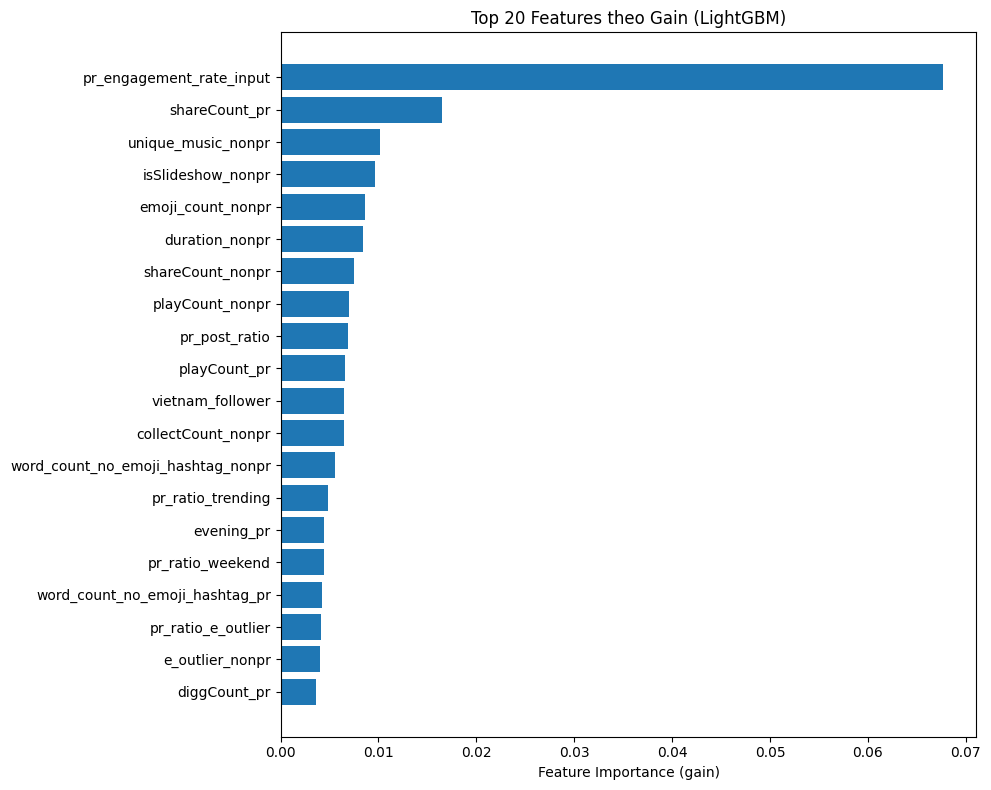

                              feature  importance_gain
59           pr_engagement_rate_input         0.067692
41                      shareCount_pr         0.016466
7                  unique_music_nonpr         0.010170
51                  isSlideshow_nonpr         0.009682
11                  emoji_count_nonpr         0.008584
38                     duration_nonpr         0.008382
42                   shareCount_nonpr         0.007521
48                    playCount_nonpr         0.007004
60                      pr_post_ratio         0.006884
47                       playCount_pr         0.006548
62                   vietnam_follower         0.006462
44                 collectCount_nonpr         0.006442
15  word_count_no_emoji_hashtag_nonpr         0.005519
35                  pr_ratio_trending         0.004861
25                         evening_pr         0.004452
32                   pr_ratio_weekend         0.004393
14     word_count_no_emoji_hashtag_pr         0.004196
56        

In [12]:
# === Hiển thị top 20 feature quan trọng nhất ===
plt.figure(figsize=(10, 8))
top_n = 20
plt.barh(importance_df['feature'][:top_n][::-1], importance_df['importance_gain'][:top_n][::-1])
plt.xlabel("Feature Importance (gain)")
plt.title("Top 20 Features theo Gain (LightGBM)")
plt.tight_layout()
plt.show()

# in bảng
print(importance_df.head(30))

## Shap

In [13]:
# Giả sử model là mô hình LightGBM đã huấn luyện
explainer = shap.TreeExplainer(model)

# Tính SHAP values cho tập train (hoặc validation)
shap_values = explainer.shap_values(X)

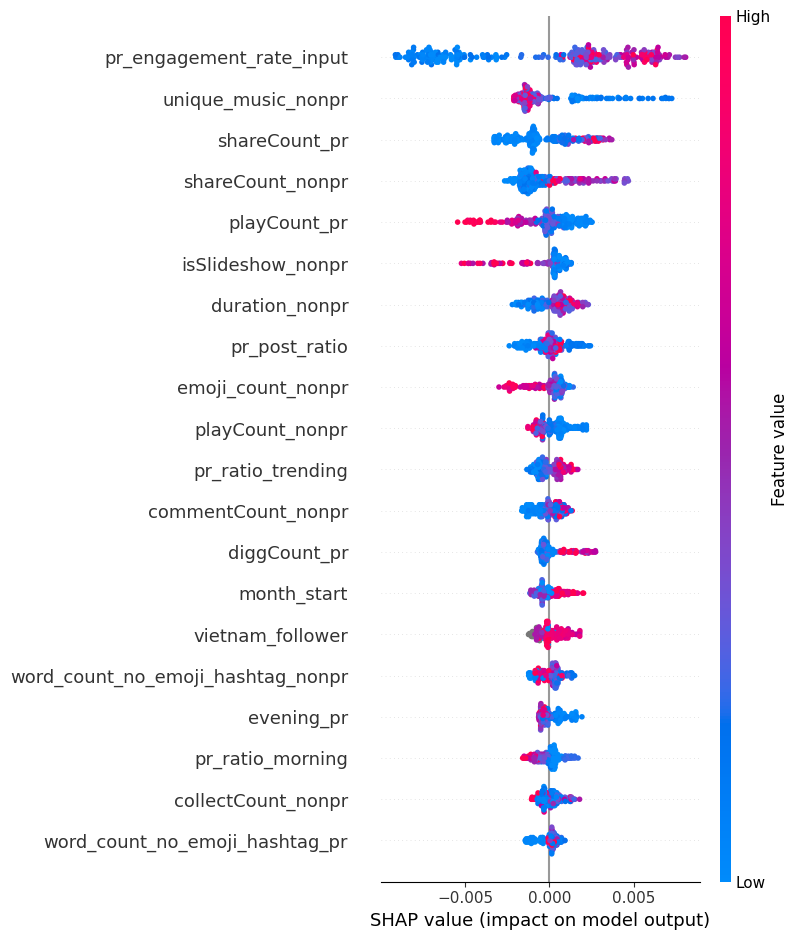

In [23]:
shap.summary_plot(shap_values, X)

## Permutation Importance

In [14]:
# Gán lại X và y để giữ nguyên cột 'kol_username' (đã bị drop trong bước trước)
X_full = train_full_df.drop(columns=[target_col])
y = train_full_df[target_col]

# Dữ liệu mô hình không có kol_username
X_model = X_full.drop(columns=['kol_username'])

# === Tính baseline RMSE ===
baseline_preds = model.predict(X_model)
baseline_rmse = np.sqrt(mean_squared_error(y, baseline_preds))

# === Tính Permutation Importance (shuffle giữa các KOL) ===
perm_results = []
feature_names = X_model.columns.tolist()

for feature in tqdm(feature_names):
    X_shuffled = X_model.copy()

    # Shuffle giá trị của feature này giữa các KOL khác nhau
    shuffled_col = []
    for kol in X_full['kol_username'].unique():
        mask = X_full['kol_username'] != kol  # lấy dữ liệu của các KOL khác
        available_vals = X_full.loc[mask, feature].values
        kol_size = (X_full['kol_username'] == kol).sum()
        shuffled_vals = np.random.choice(available_vals, size=kol_size, replace=True)
        shuffled_col.append(shuffled_vals)

    X_shuffled[feature] = np.concatenate(shuffled_col)

    if feature in categorical_features:
        # Khôi phục lại dtype category và categories ban đầu
        X_shuffled[feature] = pd.Categorical(
            X_shuffled[feature],
            categories=X_model[feature].cat.categories
        )

    # Dự đoán lại
    y_pred_shuffled = model.predict(X_shuffled)
    rmse_shuffled = np.sqrt(mean_squared_error(y, y_pred_shuffled))
    
    importance = rmse_shuffled - baseline_rmse
    perm_results.append((feature, importance))

100%|██████████| 63/63 [00:02<00:00, 23.51it/s]


In [15]:
# Chuyển sang DataFrame và sắp xếp
perm_df = pd.DataFrame(perm_results, columns=["feature", "perm_importance"])
perm_df = perm_df.sort_values(by="perm_importance", ascending=False)

# In ra top 30 feature
print(perm_df.head(30))

                              feature  perm_importance
59           pr_engagement_rate_input         0.006736
7                  unique_music_nonpr         0.002456
42                   shareCount_nonpr         0.001947
41                      shareCount_pr         0.001791
47                       playCount_pr         0.001492
51                  isSlideshow_nonpr         0.001128
60                      pr_post_ratio         0.000947
38                     duration_nonpr         0.000931
11                  emoji_count_nonpr         0.000751
46                 commentCount_nonpr         0.000624
44                 collectCount_nonpr         0.000615
0                         month_start         0.000592
57                    e_outlier_nonpr         0.000561
48                    playCount_nonpr         0.000513
35                  pr_ratio_trending         0.000468
39                       diggCount_pr         0.000438
62                   vietnam_follower         0.000433
14     wor

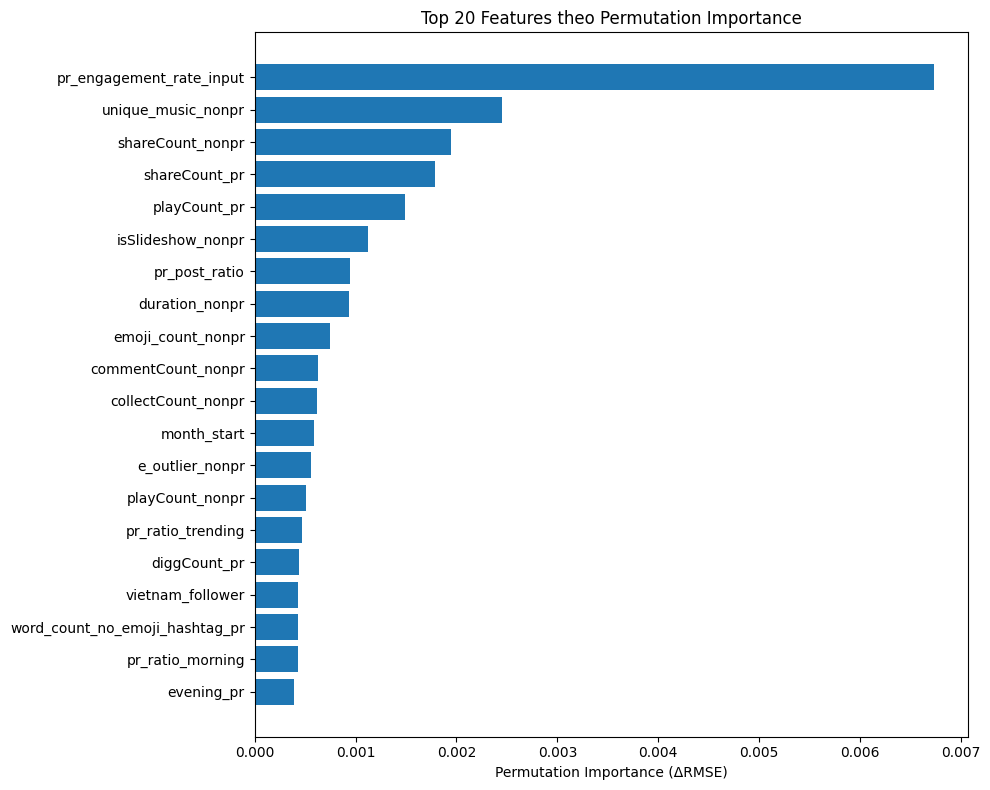

In [16]:
# Chọn số lượng feature hiển thị
top_n = 20
top_features = perm_df.head(top_n)

# Vẽ biểu đồ
plt.figure(figsize=(10, 8))
plt.barh(top_features["feature"][::-1], top_features["perm_importance"][::-1])
plt.xlabel("Permutation Importance (ΔRMSE)")
plt.title(f"Top {top_n} Features theo Permutation Importance")
plt.tight_layout()
plt.show()

In [22]:
# 1. === Feature Importance by Gain ===
top_gain = importance_df.sort_values(by='importance_gain', ascending=False).head(15)
gain_features = set(top_gain['feature'])

# 2. === SHAP ===
shap_abs_mean = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': shap_abs_mean
}).sort_values(by='mean_abs_shap', ascending=False)
shap_features = set(shap_df.head(15)['feature'])

# 3. === Permutation Importance ===
top_perm = perm_df.sort_values(by='perm_importance', ascending=False).head(15)
perm_features = set(top_perm['feature'])

# === Union: giữ tất cả các feature xuất hiện trong ít nhất 1 phương pháp
final_features = list(gain_features | shap_features | perm_features)

# In ra kết quả
print("✅ Final selected features (xuất hiện trong ít nhất 1 phương pháp):")
print(final_features)

✅ Final selected features (xuất hiện trong ít nhất 1 phương pháp):
['evening_pr', 'e_outlier_nonpr', 'collectCount_nonpr', 'shareCount_pr', 'duration_nonpr', 'playCount_nonpr', 'unique_music_nonpr', 'pr_engagement_rate_input', 'playCount_pr', 'month_start', 'pr_ratio_trending', 'emoji_count_nonpr', 'pr_post_ratio', 'diggCount_pr', 'vietnam_follower', 'word_count_no_emoji_hashtag_nonpr', 'commentCount_nonpr', 'shareCount_nonpr', 'isSlideshow_nonpr']


In [23]:
final_features

['evening_pr',
 'e_outlier_nonpr',
 'collectCount_nonpr',
 'shareCount_pr',
 'duration_nonpr',
 'playCount_nonpr',
 'unique_music_nonpr',
 'pr_engagement_rate_input',
 'playCount_pr',
 'month_start',
 'pr_ratio_trending',
 'emoji_count_nonpr',
 'pr_post_ratio',
 'diggCount_pr',
 'vietnam_follower',
 'word_count_no_emoji_hashtag_nonpr',
 'commentCount_nonpr',
 'shareCount_nonpr',
 'isSlideshow_nonpr']

In [24]:
len(final_features)


19

---
# Training models

đánh giá trên các models sau đây:

1. `RandomForestRegressor`

2. `ExtraTreesRegressor`

3. `HistGradientBoostingRegressor`

4. `XGBoost`

5. `LightGBM`

6. `CatBoost`

7. `Stacking / Blending models`

In [25]:
len(list(train_full_df.columns))

65

In [26]:
train_local_df, dev_df = split_train_test(train_full_df)
# Xác định các cột cần giữ lại
cols_to_keep = final_features + ['EngagementRateOnPRPost_target']

if 'kol_username' in train_full_df.columns:
    cols_to_keep.append('kol_username')

# Gán lại để thay đổi trực tiếp
train_full_df = train_full_df[cols_to_keep].copy()
train_local_df = train_local_df[cols_to_keep].copy()
dev_df = dev_df[cols_to_keep].copy()
test_df = test_df[cols_to_keep].copy()


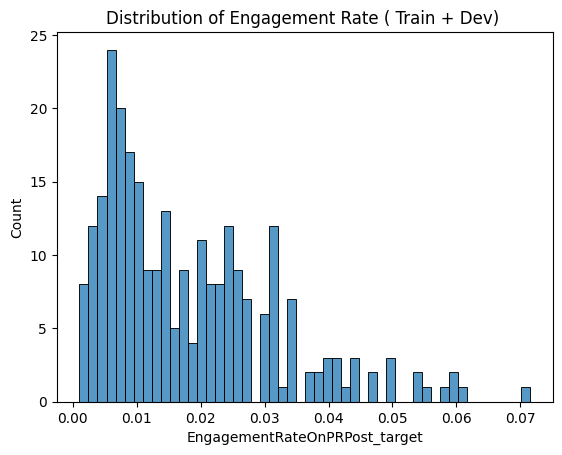

In [47]:
sns.histplot(train_full_df['EngagementRateOnPRPost_target'], bins=50)
plt.title("Distribution of Engagement Rate ( Train + Dev) ")
plt.show()

In [49]:
train_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267 entries, 369 to 247
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   pr_engagement_rate_input           267 non-null    float64
 1   unique_music_nonpr                 267 non-null    int64  
 2   shareCount_pr                      267 non-null    int64  
 3   shareCount_nonpr                   267 non-null    int64  
 4   playCount_pr                       267 non-null    int64  
 5   isSlideshow_nonpr                  267 non-null    int64  
 6   duration_nonpr                     267 non-null    int64  
 7   pr_post_ratio                      267 non-null    float64
 8   emoji_count_nonpr                  267 non-null    int64  
 9   playCount_nonpr                    267 non-null    int64  
 10  pr_ratio_trending                  267 non-null    float64
 11  collectCount_nonpr                 267 non-null    int64  
 1

In [25]:
train_full_df.dtypes

total_posts_nonpr                      int64
pr_ratio_trending                    float64
pr_post_ratio                        float64
emoji_count_nonpr                      int64
commentCount_nonpr                     int64
pr_engagement_rate_input             float64
evening_pr                             int64
hashtag_count_pr                       int64
playCount_nonpr                        int64
commentCount_pr                        int64
diggCount_pr                           int64
emoji_count_pr                         int64
hashtag_count_nonpr                    int64
collectCount_pr                        int64
is_trending_nonpr                      int64
follower_change_in_input_window      float64
pr_ratio_evening                     float64
pr_ratio_morning                     float64
pr_ratio_e_outlier                   float64
duration_nonpr                         int64
late_night_nonpr                       int64
pr_ratio_weekend                     float64
diggCount_

## RamdomForest

In [191]:
# ========= Dữ liệu =========
X_train = train_local_df[final_features]
y_train = train_local_df['EngagementRateOnPRPost_target']
X_val = dev_df[final_features]
y_val = dev_df['EngagementRateOnPRPost_target']

# ========= Tối ưu với Optuna =========
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }
    
    rf_model = RandomForestRegressor(**params)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective_rf, n_trials=100)

# ========= Kết quả =========
rf_best_params_v1 = study.best_trial.params
print("✅ Best params:", rf_best_params_v1)

# ========= Huấn luyện lại trên toàn bộ train_full_df =========
X_full = train_full_df[final_features]
y_full = train_full_df['EngagementRateOnPRPost_target']

rf_model_optuna_v1 = RandomForestRegressor(**rf_best_params_v1)
rf_model_optuna_v1.fit(X_full, y_full)

# ========= Lưu lại =========
os.makedirs("model_version", exist_ok=True)
# Đường dẫn lưu file
model_path = "./model_version/rf_model_optuna_v1.pkl"

# Lưu mô hình
joblib.dump(rf_model_optuna_v1, model_path)
print(f"✅ Đã lưu mô hình tại {model_path}")


[I 2025-06-24 20:11:22,397] A new study created in memory with name: no-name-d780bb5e-28bc-4e81-9930-b4834a611272
[I 2025-06-24 20:11:23,164] Trial 0 finished with value: 0.011454649258577487 and parameters: {'n_estimators': 300, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.011454649258577487.
[I 2025-06-24 20:11:23,340] Trial 1 finished with value: 0.012342484315868695 and parameters: {'n_estimators': 100, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.011454649258577487.
[I 2025-06-24 20:11:24,225] Trial 2 finished with value: 0.010031568409547095 and parameters: {'n_estimators': 500, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 2 with value: 0.010031568409547095.
[I 2025-06-24 20:11:24,817] Trial 3 finished with value: 0.009950

✅ Best params: {'n_estimators': 600, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True}
✅ Đã lưu mô hình tại ./model_version/rf_model_optuna_v1.pkl


In [195]:
# === Dữ liệu test ===
X_test = test_df[final_features]
y_test = test_df['EngagementRateOnPRPost_target']

# === Dự đoán ===
y_pred_test = rf_model_optuna_v1.predict(X_test)

# === Tính các chỉ số đánh giá ===
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mean_y_test = y_test.mean()
mae_relative = mae_test / mean_y_test

# === In kết quả ===
print(f"RMSE trên tập test: {rmse_test:.4f}")
print(f"R² score trên tập test: {r2_test:.4f}")
print(f"MAE score trên tập test: {mae_test:.4f}")
print(f"Mean của target trên test: {mean_y_test:.4f}")
print(f"Tỷ lệ MAE / mean target: {mae_relative:.2%}")  # in dưới dạng phần trăm

RMSE trên tập test: 0.0445
R² score trên tập test: -0.0382
MAE score trên tập test: 0.0166
Mean của target trên test: 0.0251
Tỷ lệ MAE / mean target: 66.12%


\- tạm ổn

## ExtraTreesRegressor

In [196]:
# ========= Dữ liệu =========
X_train = train_local_df[final_features]
y_train = train_local_df['EngagementRateOnPRPost_target']
X_val = dev_df[final_features]
y_val = dev_df['EngagementRateOnPRPost_target']

# ========= Tối ưu với Optuna (theo MAE) =========
def objective_et(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    et_model = ExtraTreesRegressor(**params)
    et_model.fit(X_train, y_train)
    y_pred = et_model.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_pred)
    return mae  # Tối ưu hóa MAE

# ========= Optuna Study =========
study_et = optuna.create_study(direction='minimize')
study_et.optimize(objective_et, n_trials=100)

# ========= Kết quả =========
et_best_params_v1 = study_et.best_trial.params
print("Best params (ExtraTrees, MAE):", et_best_params_v1)

# ========= Huấn luyện lại trên toàn bộ train_full_df =========
X_full = train_full_df[final_features]
y_full = train_full_df['EngagementRateOnPRPost_target']

et_model_optuna_v1 = ExtraTreesRegressor(**et_best_params_v1)
et_model_optuna_v1.fit(X_full, y_full)

# ========= Lưu lại =========
os.makedirs("model_version", exist_ok=True)
model_path = "./model_version/et_model_optuna_v1.pkl"
joblib.dump(et_model_optuna_v1, model_path)
print(f"Đã lưu mô hình tại {model_path}")


[I 2025-06-24 20:32:58,359] A new study created in memory with name: no-name-593d4f27-d174-4793-a3f7-2c82684deab9
[I 2025-06-24 20:32:59,643] Trial 0 finished with value: 0.010078370202326728 and parameters: {'n_estimators': 800, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.010078370202326728.
[I 2025-06-24 20:33:00,289] Trial 1 finished with value: 0.010341873236926048 and parameters: {'n_estimators': 500, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.010078370202326728.
[I 2025-06-24 20:33:01,206] Trial 2 finished with value: 0.009954104614475085 and parameters: {'n_estimators': 700, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 0.009954104614475085.
[I 2025-06-24 20:33:02,958] Trial 3 finished with value: 0.01

Best params (ExtraTrees, MAE): {'n_estimators': 300, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False}
Đã lưu mô hình tại ./model_version/et_model_optuna_v1.pkl


In [197]:
# === Dữ liệu test ===
X_test = test_df[final_features]
y_test = test_df['EngagementRateOnPRPost_target']

# === Dự đoán ===
y_pred_test = et_model_optuna_v1.predict(X_test)

# === Tính các chỉ số đánh giá ===
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mean_y_test = y_test.mean()
mae_relative = mae_test / mean_y_test

# === In kết quả ===
print(f"RMSE trên tập test: {rmse_test:.4f}")
print(f"R² score trên tập test: {r2_test:.4f}")
print(f"MAE score trên tập test: {mae_test:.4f}")
print(f"Mean của target trên test: {mean_y_test:.4f}")
print(f"Tỷ lệ MAE / mean target: {mae_relative:.2%}")  # in dưới dạng phần trăm

RMSE trên tập test: 0.0432
R² score trên tập test: 0.0204
MAE score trên tập test: 0.0157
Mean của target trên test: 0.0251
Tỷ lệ MAE / mean target: 62.50%


## HistGradientBoostingRegressor

In [198]:
# ========= Dữ liệu =========
X_train = train_local_df[final_features]
y_train = train_local_df['EngagementRateOnPRPost_target']
X_val = dev_df[final_features]
y_val = dev_df['EngagementRateOnPRPost_target']

# ========= Tối ưu với Optuna (theo MAE) =========
def objective_hgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_iter': trial.suggest_int('max_iter', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 50),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.0, 1.0),
        'early_stopping': False,
        'random_state': 42
    }

    hgb_model = HistGradientBoostingRegressor(**params)
    hgb_model.fit(X_train, y_train)
    y_pred = hgb_model.predict(X_val)
    
    # === ✅ Tối ưu hóa theo MAE thay vì RMSE
    mae = mean_absolute_error(y_val, y_pred)
    return mae

# ========= Thực hiện tối ưu =========
study_hgb = optuna.create_study(direction='minimize')
study_hgb.optimize(objective_hgb, n_trials=100)

# ========= Kết quả =========
hgb_best_params_v1 = study_hgb.best_trial.params
print("✅ Best params (HistGradientBoosting, MAE):", hgb_best_params_v1)

# ========= Huấn luyện lại trên toàn bộ train_full_df =========
X_full = train_full_df[final_features]
y_full = train_full_df['EngagementRateOnPRPost_target']

hgb_model_optuna_v1 = HistGradientBoostingRegressor(**hgb_best_params_v1)
hgb_model_optuna_v1.fit(X_full, y_full)

# ========= Lưu lại =========
os.makedirs("model_version", exist_ok=True)
model_path = "./model_version/hgb_model_optuna_v1.pkl"
joblib.dump(hgb_model_optuna_v1, model_path)
print(f"✅ Đã lưu mô hình tại {model_path}")


[I 2025-06-24 20:36:23,646] A new study created in memory with name: no-name-4dc0f32a-5f4a-4f94-b9b2-7bb89248ee10
[I 2025-06-24 20:36:24,805] Trial 0 finished with value: 0.010641748756730086 and parameters: {'learning_rate': 0.1341522477209402, 'max_iter': 700, 'max_depth': 7, 'min_samples_leaf': 20, 'l2_regularization': 0.46024749735894677}. Best is trial 0 with value: 0.010641748756730086.
[I 2025-06-24 20:36:25,374] Trial 1 finished with value: 0.010142946850906642 and parameters: {'learning_rate': 0.018136019282483457, 'max_iter': 700, 'max_depth': 27, 'min_samples_leaf': 18, 'l2_regularization': 0.6991777549554136}. Best is trial 1 with value: 0.010142946850906642.
[I 2025-06-24 20:36:25,938] Trial 2 finished with value: 0.0099683098911717 and parameters: {'learning_rate': 0.12222835299559295, 'max_iter': 400, 'max_depth': 14, 'min_samples_leaf': 10, 'l2_regularization': 0.8276888854143755}. Best is trial 2 with value: 0.0099683098911717.
[I 2025-06-24 20:36:26,212] Trial 3 finis

✅ Best params (HistGradientBoosting, MAE): {'learning_rate': 0.05844227254395068, 'max_iter': 300, 'max_depth': 9, 'min_samples_leaf': 11, 'l2_regularization': 0.19223658259086954}
✅ Đã lưu mô hình tại ./model_version/hgb_model_optuna_v1.pkl


In [199]:
# === Dữ liệu test ===
X_test = test_df[final_features]
y_test = test_df['EngagementRateOnPRPost_target']

# === Dự đoán ===
y_pred_test = hgb_model_optuna_v1.predict(X_test)

# === Tính các chỉ số đánh giá ===
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mean_y_test = y_test.mean()
mae_relative = mae_test / mean_y_test

# === In kết quả ===
print(f"RMSE trên tập test: {rmse_test:.4f}")
print(f"R² score trên tập test: {r2_test:.4f}")
print(f"MAE score trên tập test: {mae_test:.4f}")
print(f"Mean của target trên test: {mean_y_test:.4f}")
print(f"Tỷ lệ MAE / mean target: {mae_relative:.2%}")  # in dưới dạng phần trăm

RMSE trên tập test: 0.0448
R² score trên tập test: -0.0530
MAE score trên tập test: 0.0164
Mean của target trên test: 0.0251
Tỷ lệ MAE / mean target: 65.40%


## XGBoost

In [200]:
# ========= Dữ liệu =========
X_train = train_local_df[final_features]
y_train = train_local_df['EngagementRateOnPRPost_target']
X_val = dev_df[final_features]
y_val = dev_df['EngagementRateOnPRPost_target']

# ========= Tối ưu với Optuna (theo MAE) =========
def objective_xgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist',
        'objective': 'reg:squarederror'
    }

    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_val)
    
    # === ✅ Tối ưu hóa theo MAE ===
    mae = mean_absolute_error(y_val, y_pred)
    return mae

# ========= Thực hiện tối ưu =========
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=100)

# ========= Kết quả =========
xgb_best_params_v1 = study_xgb.best_trial.params
print("✅ Best params (XGBoost, MAE):", xgb_best_params_v1)

# ========= Huấn luyện lại trên toàn bộ train_full_df =========
X_full = train_full_df[final_features]
y_full = train_full_df['EngagementRateOnPRPost_target']

xgb_model_optuna_v1 = xgb.XGBRegressor(**xgb_best_params_v1)
xgb_model_optuna_v1.fit(X_full, y_full)

# ========= Lưu lại =========
os.makedirs("model_version", exist_ok=True)
model_path = "./model_version/xgb_model_optuna_v1.pkl"
joblib.dump(xgb_model_optuna_v1, model_path)
print(f"✅ Đã lưu mô hình tại {model_path}")


[I 2025-06-24 20:38:47,237] A new study created in memory with name: no-name-309cca2d-6905-4c15-9e3c-2b506a80bc82
[I 2025-06-24 20:38:47,791] Trial 0 finished with value: 0.011442872945644398 and parameters: {'learning_rate': 0.05697723591120032, 'n_estimators': 600, 'max_depth': 11, 'min_child_weight': 2, 'subsample': 0.6701560500323525, 'colsample_bytree': 0.9081985469313592, 'gamma': 4.232987153203778, 'reg_alpha': 0.08165410836301457, 'reg_lambda': 0.0643413765519929}. Best is trial 0 with value: 0.011442872945644398.
[I 2025-06-24 20:38:48,336] Trial 1 finished with value: 0.011447300697445451 and parameters: {'learning_rate': 0.26966337906234195, 'n_estimators': 700, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.5383910349821358, 'colsample_bytree': 0.9506363709920463, 'gamma': 2.858704427324189, 'reg_alpha': 0.3513379814215717, 'reg_lambda': 0.4753606316762664}. Best is trial 0 with value: 0.011442872945644398.
[I 2025-06-24 20:38:48,632] Trial 2 finished with value: 0.

✅ Best params (XGBoost, MAE): {'learning_rate': 0.14774236606416655, 'n_estimators': 200, 'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.5647921602523809, 'colsample_bytree': 0.9276206900383144, 'gamma': 3.1630791364385407, 'reg_alpha': 0.019388187382004176, 'reg_lambda': 0.3747335154476224}
✅ Đã lưu mô hình tại ./model_version/xgb_model_optuna_v1.pkl


In [201]:
# === Dữ liệu test ===
X_test = test_df[final_features]
y_test = test_df['EngagementRateOnPRPost_target']

# === Dự đoán ===
y_pred_test = xgb_model_optuna_v1.predict(X_test)

# === Tính các chỉ số đánh giá ===
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mean_y_test = y_test.mean()
mae_relative = mae_test / mean_y_test

# === In kết quả ===
print(f"RMSE trên tập test: {rmse_test:.4f}")
print(f"R² score trên tập test: {r2_test:.4f}")
print(f"MAE score trên tập test: {mae_test:.4f}")
print(f"Mean của target trên test: {mean_y_test:.4f}")
print(f"Tỷ lệ MAE / mean target: {mae_relative:.2%}")  # in dưới dạng phần trăm

RMSE trên tập test: 0.0442
R² score trên tập test: -0.0254
MAE score trên tập test: 0.0167
Mean của target trên test: 0.0251
Tỷ lệ MAE / mean target: 66.74%


## LightGBM

In [202]:
# ========= Dữ liệu =========
X_train = train_local_df[final_features]
y_train = train_local_df['EngagementRateOnPRPost_target']
X_val = dev_df[final_features]
y_val = dev_df['EngagementRateOnPRPost_target']

# ========= Tối ưu với Optuna (theo MAE) =========
def objective_lgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }

    lgb_model = LGBMRegressor(**params)
    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_val)

    # === ✅ Sử dụng MAE thay cho RMSE
    mae = mean_absolute_error(y_val, y_pred)
    return mae

# ========= Thực hiện tối ưu =========
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=100)

# ========= Kết quả =========
lgb_best_params_v1 = study_lgb.best_trial.params
print("✅ Best params (LightGBM, MAE):", lgb_best_params_v1)

# ========= Huấn luyện lại trên toàn bộ train_full_df =========
X_full = train_full_df[final_features]
y_full = train_full_df['EngagementRateOnPRPost_target']

lgb_model_optuna_v1 = LGBMRegressor(**lgb_best_params_v1)
lgb_model_optuna_v1.fit(X_full, y_full)

# ========= Lưu lại =========
os.makedirs("model_version", exist_ok=True)
model_path = "./model_version/lgb_model_optuna_v1.pkl"
joblib.dump(lgb_model_optuna_v1, model_path)
print(f"✅ Đã lưu mô hình tại {model_path}")


[I 2025-06-24 20:40:37,186] A new study created in memory with name: no-name-24323eed-1d14-4d4b-9531-d832a6fd40f0


[I 2025-06-24 20:40:37,693] Trial 0 finished with value: 0.01144730074795968 and parameters: {'learning_rate': 0.22787118558310854, 'n_estimators': 900, 'max_depth': 17, 'num_leaves': 229, 'min_child_samples': 55, 'subsample': 0.8460899676659377, 'colsample_bytree': 0.793370430484569, 'reg_alpha': 0.8011345458549634, 'reg_lambda': 0.22409245189289806}. Best is trial 0 with value: 0.01144730074795968.
[I 2025-06-24 20:40:37,865] Trial 1 finished with value: 0.01144730074795968 and parameters: {'learning_rate': 0.028658877930661623, 'n_estimators': 700, 'max_depth': 17, 'num_leaves': 285, 'min_child_samples': 52, 'subsample': 0.8556590455976119, 'colsample_bytree': 0.5371386959180666, 'reg_alpha': 0.5958277709615025, 'reg_lambda': 0.5523066862874462}. Best is trial 0 with value: 0.01144730074795968.
[I 2025-06-24 20:40:37,975] Trial 2 finished with value: 0.01144730074795968 and parameters: {'learning_rate': 0.28245328339459275, 'n_estimators': 500, 'max_depth': 17, 'num_leaves': 46, 'mi

✅ Best params (LightGBM, MAE): {'learning_rate': 0.21887079051256284, 'n_estimators': 100, 'max_depth': 4, 'num_leaves': 106, 'min_child_samples': 22, 'subsample': 0.6433679732517147, 'colsample_bytree': 0.8824244949539293, 'reg_alpha': 0.09047576335608197, 'reg_lambda': 0.07793415638402454}
✅ Đã lưu mô hình tại ./model_version/lgb_model_optuna_v1.pkl


In [203]:
# === Dữ liệu test ===
X_test = test_df[final_features]
y_test = test_df['EngagementRateOnPRPost_target']

# === Dự đoán ===
y_pred_test = lgb_model_optuna_v1.predict(X_test)

# === Tính các chỉ số đánh giá ===
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mean_y_test = y_test.mean()
mae_relative = mae_test / mean_y_test

# === In kết quả ===
print(f"RMSE trên tập test: {rmse_test:.4f}")
print(f"R² score trên tập test: {r2_test:.4f}")
print(f"MAE score trên tập test: {mae_test:.4f}")
print(f"Mean của target trên test: {mean_y_test:.4f}")
print(f"Tỷ lệ MAE / mean target: {mae_relative:.2%}")  # in dưới dạng phần trăm

RMSE trên tập test: 0.0445
R² score trên tập test: -0.0422
MAE score trên tập test: 0.0167
Mean của target trên test: 0.0251
Tỷ lệ MAE / mean target: 66.55%


## CatBoost

In [204]:
# ========= Dữ liệu =========
X_train = train_local_df[final_features]
y_train = train_local_df['EngagementRateOnPRPost_target']
X_val = dev_df[final_features]
y_val = dev_df['EngagementRateOnPRPost_target']

# ========= Tối ưu với Optuna (theo MAE) =========
def objective_cat(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'iterations': trial.suggest_int('iterations', 200, 1000, step=100),
        'random_strength': trial.suggest_float('random_strength', 1.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_seed': 42,
        'verbose': 0
    }

    cat_model = CatBoostRegressor(**params)
    cat_model.fit(X_train, y_train)
    y_pred = cat_model.predict(X_val)

    # === ✅ Tối ưu theo MAE
    mae = mean_absolute_error(y_val, y_pred)
    return mae

# ========= Thực hiện tối ưu =========
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=100)

# ========= Kết quả =========
cat_best_params_v1 = study_cat.best_trial.params
print("✅ Best params (CatBoost, MAE):", cat_best_params_v1)

# ========= Huấn luyện lại trên toàn bộ train_full_df =========
X_full = train_full_df[final_features]
y_full = train_full_df['EngagementRateOnPRPost_target']

cat_model_optuna_v1 = CatBoostRegressor(**cat_best_params_v1)
cat_model_optuna_v1.fit(X_full, y_full)

# ========= Lưu lại =========
os.makedirs("model_version", exist_ok=True)
model_path = "./model_version/cat_model_optuna_v1.pkl"
joblib.dump(cat_model_optuna_v1, model_path)
print(f"✅ Đã lưu mô hình tại {model_path}")


[I 2025-06-24 20:42:20,388] A new study created in memory with name: no-name-5aec3a55-4944-466b-978d-2572a1fc24ed
[I 2025-06-24 20:42:22,827] Trial 0 finished with value: 0.009667115467813585 and parameters: {'learning_rate': 0.16254640014190308, 'depth': 7, 'l2_leaf_reg': 6.491776058085047, 'iterations': 600, 'random_strength': 4.053975348983027, 'bagging_temperature': 0.4786302019188047, 'border_count': 245}. Best is trial 0 with value: 0.009667115467813585.
[I 2025-06-24 20:42:25,503] Trial 1 finished with value: 0.009654501227808558 and parameters: {'learning_rate': 0.06589305791538376, 'depth': 8, 'l2_leaf_reg': 3.412771349499815, 'iterations': 700, 'random_strength': 2.5475443914904368, 'bagging_temperature': 0.30119477280983054, 'border_count': 141}. Best is trial 1 with value: 0.009654501227808558.
[I 2025-06-24 20:42:25,963] Trial 2 finished with value: 0.010122619932241056 and parameters: {'learning_rate': 0.014729573032369454, 'depth': 6, 'l2_leaf_reg': 2.9580740366795526, '

✅ Best params (CatBoost, MAE): {'learning_rate': 0.05461431665615249, 'depth': 4, 'l2_leaf_reg': 7.4253281999818155, 'iterations': 200, 'random_strength': 7.376960536787396, 'bagging_temperature': 0.5197927916960075, 'border_count': 66}
0:	learn: 0.0133658	total: 1.77ms	remaining: 352ms
1:	learn: 0.0132896	total: 2.18ms	remaining: 216ms
2:	learn: 0.0131514	total: 2.6ms	remaining: 171ms
3:	learn: 0.0131441	total: 2.99ms	remaining: 146ms
4:	learn: 0.0130367	total: 3.39ms	remaining: 132ms
5:	learn: 0.0129961	total: 3.78ms	remaining: 122ms
6:	learn: 0.0129297	total: 4.17ms	remaining: 115ms
7:	learn: 0.0128591	total: 4.55ms	remaining: 109ms
8:	learn: 0.0128014	total: 4.94ms	remaining: 105ms
9:	learn: 0.0127184	total: 5.33ms	remaining: 101ms
10:	learn: 0.0126984	total: 5.71ms	remaining: 98.2ms
11:	learn: 0.0126472	total: 6.09ms	remaining: 95.5ms
12:	learn: 0.0125118	total: 6.47ms	remaining: 93.1ms
13:	learn: 0.0124477	total: 6.85ms	remaining: 91.1ms
14:	learn: 0.0123822	total: 7.25ms	remaini

In [205]:
# === Dữ liệu test ===
X_test = test_df[final_features]
y_test = test_df['EngagementRateOnPRPost_target']

# === Dự đoán ===
y_pred_test = cat_model_optuna_v1.predict(X_test)

# === Tính các chỉ số đánh giá ===
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mean_y_test = y_test.mean()
mae_relative = mae_test / mean_y_test

# === In kết quả ===
print(f"RMSE trên tập test: {rmse_test:.4f}")
print(f"R² score trên tập test: {r2_test:.4f}")
print(f"MAE score trên tập test: {mae_test:.4f}")
print(f"Mean của target trên test: {mean_y_test:.4f}")
print(f"Tỷ lệ MAE / mean target: {mae_relative:.2%}")  # in dưới dạng phần trăm

RMSE trên tập test: 0.0439
R² score trên tập test: -0.0137
MAE score trên tập test: 0.0157
Mean của target trên test: 0.0251
Tỷ lệ MAE / mean target: 62.69%


## Stacking

In [215]:
# === Base learners tốt nhất ===
estimators = [
    ('et', ExtraTreesRegressor(**et_best_params_v1)),
    ('cat', CatBoostRegressor(**cat_best_params_v1, verbose=0)),
]

# === Final estimator: Ridge (ổn định, ít overfit) ===
final_estimator = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
)
# === Xử lý NaN bằng cách điền trung bình ===
imputer = SimpleImputer(strategy='median')
X_full = imputer.fit_transform(train_full_df[final_features])
y_full = train_full_df['EngagementRateOnPRPost_target']

# === StackingRegressor ===
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    passthrough=True,
    n_jobs=-1
)

# === Huấn luyện model stacking ===
stacking_model.fit(X_full, y_full)

,estimators,"[('et', ...), ('cat', ...)]"
,final_estimator,GradientBoost...ndom_state=42)
,cv,None
,n_jobs,-1
,passthrough,True
,verbose,0
,n_estimators,300
,criterion,'squared_error'
,max_depth,18
,min_samples_split,5
,min_samples_leaf,3


In [216]:
# === Dự đoán trên test_df ===
X_test = test_df[final_features]
X_test_imputed = imputer.transform(X_test)
y_test = test_df['EngagementRateOnPRPost_target']

y_pred_test_stacking = stacking_model.predict(X_test_imputed)

# === Đánh giá ===
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_stacking))
mae = mean_absolute_error(y_test, y_pred_test_stacking)
r2 = r2_score(y_test, y_pred_test_stacking)
mean_target = y_test.mean()
mae_ratio = mae / mean_target * 100

print(f"✅ Đánh giá mô hình Stacking cải tiến trên tập test:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"Mean của target trên test: {mean_target:.4f}")
print(f"Tỷ lệ MAE / mean target: {mae_ratio:.2f}%")


✅ Đánh giá mô hình Stacking cải tiến trên tập test:
RMSE: 0.0428
MAE: 0.0168
R²: 0.0375
Mean của target trên test: 0.0251
Tỷ lệ MAE / mean target: 66.80%


In [221]:
# === Dự đoán riêng của ExtraTrees và Stacking ===
y_pred_et = et_model_optuna_v1.predict(X_test_imputed)
y_pred_stack = y_pred_test_stacking  # đã có sẵn

# === Trung bình hai mô hình ===
y_pred_avg = (y_pred_et + y_pred_stack) / 2

# === Đánh giá ===
rmse_blend = np.sqrt(mean_squared_error(y_test, y_pred_avg))
mae_blend = mean_absolute_error(y_test, y_pred_avg)
r2_blend = r2_score(y_test, y_pred_avg)
mean_target = y_test.mean()
mae_ratio = mae_blend / mean_target * 100

# === In kết quả ===
print("✅ Đánh giá mô hình Blending (Stacking + ExtraTrees):")
print(f"RMSE: {rmse_blend:.4f}")
print(f"MAE: {mae_blend:.4f}")
print(f"R²: {r2_blend:.4f}")
print(f"Mean của target trên test: {mean_target:.4f}")
print(f"Tỷ lệ MAE / mean target: {mae_ratio:.2f}%")

✅ Đánh giá mô hình Blending (Stacking + ExtraTrees):
RMSE: 0.0430
MAE: 0.0161
R²: 0.0307
Mean của target trên test: 0.0251
Tỷ lệ MAE / mean target: 64.40%


/Users/macbook/Desktop/DS304_perfume_investigation/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(


In [222]:
# === Dự đoán từng mô hình ===
y_pred_et = et_model_optuna_v1.predict(X_test_imputed)
y_pred_stack = stacking_model.predict(X_test_imputed)
y_pred_cat = cat_model_optuna_v1.predict(X_test_imputed)

# === Blending: Trung bình dự đoán của 3 mô hình ===
y_pred_blend3 = (y_pred_et + y_pred_stack + y_pred_cat) / 3

# === Đánh giá hiệu quả ===
rmse_blend3 = np.sqrt(mean_squared_error(y_test, y_pred_blend3))
mae_blend3 = mean_absolute_error(y_test, y_pred_blend3)
r2_blend3 = r2_score(y_test, y_pred_blend3)
mean_target = y_test.mean()
mae_ratio = mae_blend3 / mean_target * 100

# === In kết quả ===
print("✅ Đánh giá mô hình Blending (ET + Stacking + CatBoost):")
print(f"RMSE: {rmse_blend3:.4f}")
print(f"MAE: {mae_blend3:.4f}")
print(f"R²: {r2_blend3:.4f}")
print(f"Mean của target trên test: {mean_target:.4f}")
print(f"Tỷ lệ MAE / mean target: {mae_ratio:.2f}%")

✅ Đánh giá mô hình Blending (ET + Stacking + CatBoost):
RMSE: 0.0432
MAE: 0.0159
R²: 0.0175
Mean của target trên test: 0.0251
Tỷ lệ MAE / mean target: 63.56%


/Users/macbook/Desktop/DS304_perfume_investigation/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(


## Weighted Blending

In [224]:
def blend_mae(weights):
    blended = weights[0]*y_pred_et + weights[1]*y_pred_stack + weights[2]*y_pred_cat
    return mean_absolute_error(y_test, blended)

# Ràng buộc: tổng trọng số = 1 và mỗi trọng số >= 0
constraints = ({'type': 'eq', 'fun': lambda w: 1 - sum(w)})
bounds = [(0, 1)] * 3
initial_weights = [1/3, 1/3, 1/3]

result = minimize(blend_mae, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
best_weights = result.x

# Áp dụng blending với trọng số tối ưu
y_pred_weighted_blend = (best_weights[0] * y_pred_et +
                         best_weights[1] * y_pred_stack +
                         best_weights[2] * y_pred_cat)

# Đánh giá lại
mae_wb = mean_absolute_error(y_test, y_pred_weighted_blend)
mae_ratio_wb = mae_wb / mean_target * 100
print("✅ Weighted Blending:")
print(f"Trọng số: ET={best_weights[0]:.2f}, Stack={best_weights[1]:.2f}, Cat={best_weights[2]:.2f}")
print(f"MAE: {mae_wb:.4f} ({mae_ratio_wb:.2f}%)")


✅ Weighted Blending:
Trọng số: ET=0.33, Stack=0.33, Cat=0.33
MAE: 0.0159 (63.56%)


In [225]:
from scipy.optimize import minimize
import numpy as np

def blend_mae(weights):
    blended = weights[0]*y_pred_et + weights[1]*y_pred_stack + weights[2]*y_pred_cat
    return mean_absolute_error(y_test, blended)

# Ràng buộc: tổng trọng số = 1
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
bounds = [(0, 1)] * 3

best_mae = float('inf')
best_weights = None

# Thử nhiều khởi tạo ngẫu nhiên
for _ in range(20):
    initial = np.random.dirichlet(np.ones(3))
    result = minimize(blend_mae, initial, method='SLSQP',
                      bounds=bounds, constraints=constraints)
    if result.fun < best_mae:
        best_mae = result.fun
        best_weights = result.x

# Dự đoán với trọng số tối ưu
y_pred_weighted_blend = (best_weights[0] * y_pred_et +
                         best_weights[1] * y_pred_stack +
                         best_weights[2] * y_pred_cat)

# Đánh giá
mae = mean_absolute_error(y_test, y_pred_weighted_blend)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_weighted_blend))
r2 = r2_score(y_test, y_pred_weighted_blend)
mae_ratio = mae / mean_target * 100

print("✅ Weighted Blending (Tối ưu lại):")
print(f"Trọng số: ET={best_weights[0]:.2f}, Stack={best_weights[1]:.2f}, Cat={best_weights[2]:.2f}")
print(f"MAE: {mae:.4f} ({mae_ratio:.2f}%)")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


✅ Weighted Blending (Tối ưu lại):
Trọng số: ET=0.32, Stack=0.08, Cat=0.59
MAE: 0.0157 (62.71%)
RMSE: 0.0436
R²: 0.0029


In [229]:
best_mae = float('inf')
best_w = None
best_rmse = None
best_r2 = None

for w in np.linspace(0, 1, 101):  # thử từ 0.00 đến 1.00, bước 0.01
    y_pred_weighted = w * y_pred_et + (1 - w) * y_pred_cat
    mae = mean_absolute_error(y_test, y_pred_weighted)
    
    if mae < best_mae:
        best_mae = mae
        best_w = w
        best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_weighted))
        best_r2 = r2_score(y_test, y_pred_weighted)

mae_ratio = best_mae / y_test.mean() * 100

print("✅ Tối ưu trọng số Blending (ET + CatBoost):")
print(f"Trọng số tốt nhất: ET={best_w:.2f}, CatBoost={1-best_w:.2f}")
print(f"MAE: {best_mae:.4f} ({mae_ratio:.2f}%)")
print(f"RMSE: {best_rmse:.4f}")
print(f"R²: {best_r2:.4f}")


✅ Tối ưu trọng số Blending (ET + CatBoost):
Trọng số tốt nhất: ET=0.62, CatBoost=0.38
MAE: 0.0157 (62.71%)
RMSE: 0.0435
R²: 0.0076


---

# Version 2

In [37]:
selected_features = [
    'pr_engagement_rate_input',
    'unique_music_nonpr',
    'shareCount_pr',
    'shareCount_nonpr',
    'playCount_pr',
    'isSlideshow_nonpr',
    'duration_nonpr',
    'pr_post_ratio',
    'emoji_count_nonpr',
    'playCount_nonpr',
    'pr_ratio_trending',
    'collectCount_nonpr',
    'commentCount_nonpr',
    'diggCount_pr',
    'vietnam_follower',
    'word_count_no_emoji_hashtag_nonpr',
    'evening_pr',
    'month_start',
    'commentCount_pr'
]

In [38]:
train_local_df, dev_df = split_train_test(train_full_df)
# Xác định các cột cần giữ lại
cols_to_keep = selected_features + ['EngagementRateOnPRPost_target']

if 'kol_username' in train_full_df.columns:
    cols_to_keep.append('kol_username')

# Gán lại để thay đổi trực tiếp
train_full_df = train_full_df[cols_to_keep].copy()
train_local_df = train_local_df[cols_to_keep].copy()
dev_df = dev_df[cols_to_keep].copy()
test_df = test_df[cols_to_keep].copy()

In [39]:
train_full_df.describe()

,pr_engagement_rate_input,unique_music_nonpr,shareCount_pr,shareCount_nonpr,playCount_pr,isSlideshow_nonpr,duration_nonpr,pr_post_ratio,emoji_count_nonpr,playCount_nonpr,pr_ratio_trending,collectCount_nonpr,commentCount_nonpr,diggCount_pr,vietnam_follower,word_count_no_emoji_hashtag_nonpr,evening_pr,month_start,commentCount_pr,EngagementRateOnPRPost_target
count,267.000000,267.000000,267.000000,267.000000,2.670000e+02,267.000000,267.000000,267.000000,267.000000,2.670000e+02,267.000000,2.670000e+02,267.000000,2.670000e+02,189.000000,267.000000,267.000000,267.000000,267.000000,267.000000
mean,0.019010,70.595506,9103.853933,46395.037453,2.730796e+07,3.524345,4856.408240,0.228437,60.689139,5.261092e+07,0.197179,1.663674e+05,20247.329588,4.590263e+05,89.952381,1076.524345,12.014981,3.003745,5523.629213,0.018100
std,0.013606,37.952103,21583.760474,59231.653689,3.710222e+07,5.763050,3065.728954,0.189067,50.400397,6.464941e+07,0.170732,2.295677e+05,23467.159434,9.061741e+05,7.871498,681.016022,11.393498,1.407547,14645.060693,0.013538
min,0.000000,8.000000,0.000000,74.000000,0.000000e+00,0.000000,320.000000,0.000000,0.000000,1.572780e+05,0.000000,2.770000e+02,169.000000,0.000000e+00,52.000000,62.000000,0.000000,1.000000,0.000000,0.001052
25%,0.008448,41.000000,1298.500000,7959.500000,6.157500e+06,0.000000,2634.500000,0.080230,24.000000,1.056243e+07,0.072300,2.729700e+04,3924.000000,7.418850e+04,90.000000,601.000000,4.000000,2.000000,557.500000,0.007510
50%,0.015230,61.000000,2813.000000,26593.000000,1.475310e+07,2.000000,4028.000000,0.176471,53.000000,2.919260e+07,0.155556,7.451200e+04,11472.000000,1.766440e+05,92.000000,859.000000,9.000000,3.000000,1298.000000,0.014295
75%,0.026935,99.000000,6147.500000,61269.000000,3.665470e+07,5.000000,6827.500000,0.320437,83.000000,6.452405e+07,0.284034,1.947770e+05,25079.000000,4.600590e+05,94.000000,1545.500000,17.000000,4.000000,3059.500000,0.025565
max,0.082192,171.000000,152475.000000,408788.000000,2.404000e+08,72.000000,15022.000000,0.825397,322.000000,3.441415e+08,1.000000,1.485488e+06,111866.000000,6.495600e+06,98.000000,3245.000000,68.000000,5.000000,113042.000000,0.071563


In [40]:
train_local_df.describe()

,pr_engagement_rate_input,unique_music_nonpr,shareCount_pr,shareCount_nonpr,playCount_pr,isSlideshow_nonpr,duration_nonpr,pr_post_ratio,emoji_count_nonpr,playCount_nonpr,pr_ratio_trending,collectCount_nonpr,commentCount_nonpr,diggCount_pr,vietnam_follower,word_count_no_emoji_hashtag_nonpr,evening_pr,month_start,commentCount_pr,EngagementRateOnPRPost_target
count,96.000000,96.000000,96.00000,96.000000,9.600000e+01,96.000000,96.000000,96.000000,96.000000,9.600000e+01,96.000000,9.600000e+01,96.000000,9.600000e+01,66.000000,96.000000,96.000000,96.000000,96.00000,96.000000
mean,0.019693,70.114583,8591.68750,37002.052083,2.707069e+07,3.250000,4880.114583,0.214797,59.677083,4.950817e+07,0.219126,1.601833e+05,19769.614583,4.593874e+05,91.151515,1054.947917,10.468750,1.500000,5202.65625,0.017548
std,0.014718,38.722731,21328.51552,40485.085353,3.843593e+07,4.023615,3040.553069,0.186995,47.276008,5.759336e+07,0.164356,2.157006e+05,22915.716352,9.784465e+05,4.795005,683.063276,9.804353,0.502625,13543.24686,0.012805
min,0.000000,16.000000,0.00000,75.000000,0.000000e+00,0.000000,807.000000,0.000000,0.000000,1.814550e+05,0.000000,3.010000e+02,169.000000,0.000000e+00,72.000000,92.000000,0.000000,1.000000,0.00000,0.001085
25%,0.009203,41.000000,823.75000,7392.500000,5.144050e+06,0.750000,2545.750000,0.080345,26.500000,1.173282e+07,0.100000,2.668325e+04,3946.500000,6.180700e+04,91.000000,591.250000,3.750000,1.000000,506.50000,0.007988
50%,0.015783,59.000000,2590.50000,19689.500000,1.240765e+07,2.000000,4082.500000,0.160456,52.500000,2.879215e+07,0.202273,6.903200e+04,9980.500000,1.769405e+05,92.000000,811.000000,7.000000,1.500000,1289.50000,0.013441
75%,0.027192,97.500000,5506.50000,60973.500000,3.474692e+07,4.000000,6769.000000,0.282432,81.500000,6.861910e+07,0.333333,1.699878e+05,24713.000000,4.673522e+05,94.000000,1427.250000,15.250000,2.000000,2986.75000,0.026103
max,0.081997,171.000000,142600.00000,185055.000000,2.291000e+08,20.000000,13892.000000,0.698413,217.000000,2.739180e+08,0.625000,1.107984e+06,102618.000000,6.495600e+06,98.000000,2967.000000,46.000000,2.000000,94131.00000,0.059455


In [41]:
dev_df.describe()

,pr_engagement_rate_input,unique_music_nonpr,shareCount_pr,shareCount_nonpr,playCount_pr,isSlideshow_nonpr,duration_nonpr,pr_post_ratio,emoji_count_nonpr,playCount_nonpr,pr_ratio_trending,collectCount_nonpr,commentCount_nonpr,diggCount_pr,vietnam_follower,word_count_no_emoji_hashtag_nonpr,evening_pr,month_start,commentCount_pr,EngagementRateOnPRPost_target
count,61.000000,61.000000,61.000000,61.000000,6.100000e+01,61.000000,61.000000,61.000000,61.000000,6.100000e+01,61.000000,6.100000e+01,61.000000,6.100000e+01,45.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,0.018221,69.852459,9900.950820,55078.442623,2.709540e+07,4.245902,4724.114754,0.245857,60.426230,5.183672e+07,0.173535,1.614267e+05,19595.360656,4.718912e+05,89.444444,1083.983607,13.885246,4.737705,5719.262295,0.019780
std,0.011646,36.454006,22080.337806,73593.927266,3.590164e+07,9.571931,3111.415370,0.198765,55.356559,6.875403e+07,0.175237,2.369138e+05,23356.878449,8.701634e+05,8.747871,676.260145,13.991781,0.772477,14725.169467,0.015711
min,0.002807,11.000000,11.000000,307.000000,1.510000e+04,0.000000,320.000000,0.006061,0.000000,5.630050e+05,0.000000,1.212000e+03,291.000000,7.200000e+01,52.000000,77.000000,0.000000,1.000000,7.000000,0.001382
25%,0.008605,41.000000,1635.000000,8483.000000,6.591600e+06,0.000000,2644.000000,0.095238,23.000000,1.064550e+07,0.054054,2.757100e+04,3315.000000,9.560700e+04,90.000000,617.000000,4.000000,5.000000,648.000000,0.007518
50%,0.014267,61.000000,3154.000000,28995.000000,1.531950e+07,2.000000,4028.000000,0.191011,53.000000,2.919260e+07,0.139535,8.556100e+04,12476.000000,1.775330e+05,91.000000,972.000000,11.000000,5.000000,1275.000000,0.015399
75%,0.026917,100.000000,6692.000000,61994.000000,2.937769e+07,5.000000,6657.000000,0.315789,87.000000,5.208530e+07,0.240741,2.090160e+05,22597.000000,4.176930e+05,93.000000,1575.000000,17.000000,5.000000,3430.000000,0.024369
max,0.056304,153.000000,150082.000000,408788.000000,2.290000e+08,72.000000,15022.000000,0.825397,322.000000,3.441415e+08,0.864865,1.485488e+06,111866.000000,5.402000e+06,98.000000,3077.000000,68.000000,5.000000,103609.000000,0.071563


In [45]:
test_df.describe()

,pr_engagement_rate_input,unique_music_nonpr,shareCount_pr,shareCount_nonpr,playCount_pr,isSlideshow_nonpr,duration_nonpr,pr_post_ratio,emoji_count_nonpr,playCount_nonpr,pr_ratio_trending,collectCount_nonpr,commentCount_nonpr,diggCount_pr,vietnam_follower,word_count_no_emoji_hashtag_nonpr,evening_pr,month_start,commentCount_pr,EngagementRateOnPRPost_target
count,69.000000,69.000000,69.000000,69.000000,6.900000e+01,69.000000,69.000000,69.000000,69.000000,6.900000e+01,69.000000,69.000000,69.000000,6.900000e+01,49.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,0.015790,70.971014,13616.086957,57283.173913,2.546317e+07,4.405797,4806.449275,0.236678,61.289855,4.251926e+07,0.154102,135658.985507,15513.579710,4.549333e+05,89.571429,1104.507246,14.724638,7.594203,5729.173913,0.025076
std,0.011371,36.385182,43067.757609,85669.712988,3.882091e+07,14.097683,3589.539494,0.217193,59.234852,5.255249e+07,0.167280,181278.258412,18741.706028,9.234752e+05,8.398909,757.109356,18.191695,1.309679,17001.946213,0.043947
min,0.000000,4.000000,0.000000,22.000000,0.000000e+00,0.000000,300.000000,0.000000,1.000000,2.515900e+04,0.000000,70.000000,55.000000,0.000000e+00,52.000000,38.000000,0.000000,1.000000,0.000000,0.001025
25%,0.006872,47.000000,1261.000000,7523.000000,5.782700e+06,0.000000,2557.000000,0.082192,20.000000,8.897200e+06,0.000000,22311.000000,4106.000000,5.704900e+04,90.000000,598.000000,5.000000,8.000000,494.000000,0.008848
50%,0.013445,67.000000,2938.000000,30829.000000,1.448290e+07,2.000000,3663.000000,0.185185,45.000000,2.788490e+07,0.118644,61497.000000,9816.000000,1.477230e+05,91.000000,888.000000,8.000000,8.000000,1094.000000,0.015141
75%,0.023762,88.000000,6676.000000,66270.000000,2.829700e+07,3.000000,5933.000000,0.314961,83.000000,4.922460e+07,0.213333,143329.000000,19596.000000,3.477740e+05,93.000000,1391.000000,19.000000,8.000000,2625.000000,0.027711
max,0.046086,174.000000,332857.000000,508959.000000,2.585000e+08,115.000000,16807.000000,0.933333,372.000000,2.657089e+08,0.951220,793500.000000,98829.000000,5.575300e+06,98.000000,3475.000000,112.000000,8.000000,126023.000000,0.359891


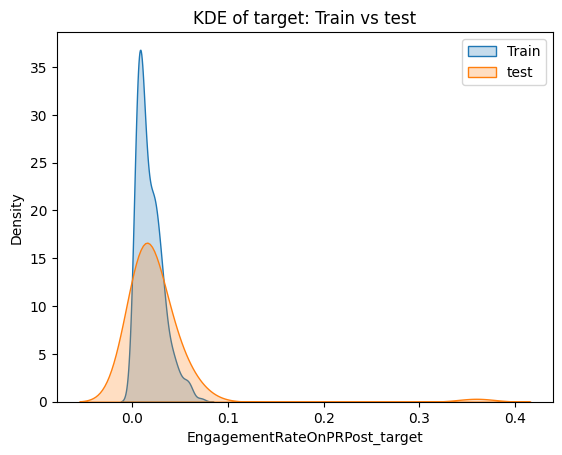

In [ ]:
sns.kdeplot(train_full_df["EngagementRateOnPRPost_target"], label="Train", fill=True)
sns.kdeplot(test_df["EngagementRateOnPRPost_target"], label="test", fill=True)
plt.title("KDE of target: Train vs test")
plt.legend()
plt.show()

In [44]:
test_df.describe()

,pr_engagement_rate_input,unique_music_nonpr,shareCount_pr,shareCount_nonpr,playCount_pr,isSlideshow_nonpr,duration_nonpr,pr_post_ratio,emoji_count_nonpr,playCount_nonpr,pr_ratio_trending,collectCount_nonpr,commentCount_nonpr,diggCount_pr,vietnam_follower,word_count_no_emoji_hashtag_nonpr,evening_pr,month_start,commentCount_pr,EngagementRateOnPRPost_target
count,69.000000,69.000000,69.000000,69.000000,6.900000e+01,69.000000,69.000000,69.000000,69.000000,6.900000e+01,69.000000,69.000000,69.000000,6.900000e+01,49.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,0.015790,70.971014,13616.086957,57283.173913,2.546317e+07,4.405797,4806.449275,0.236678,61.289855,4.251926e+07,0.154102,135658.985507,15513.579710,4.549333e+05,89.571429,1104.507246,14.724638,7.594203,5729.173913,0.025076
std,0.011371,36.385182,43067.757609,85669.712988,3.882091e+07,14.097683,3589.539494,0.217193,59.234852,5.255249e+07,0.167280,181278.258412,18741.706028,9.234752e+05,8.398909,757.109356,18.191695,1.309679,17001.946213,0.043947
min,0.000000,4.000000,0.000000,22.000000,0.000000e+00,0.000000,300.000000,0.000000,1.000000,2.515900e+04,0.000000,70.000000,55.000000,0.000000e+00,52.000000,38.000000,0.000000,1.000000,0.000000,0.001025
25%,0.006872,47.000000,1261.000000,7523.000000,5.782700e+06,0.000000,2557.000000,0.082192,20.000000,8.897200e+06,0.000000,22311.000000,4106.000000,5.704900e+04,90.000000,598.000000,5.000000,8.000000,494.000000,0.008848
50%,0.013445,67.000000,2938.000000,30829.000000,1.448290e+07,2.000000,3663.000000,0.185185,45.000000,2.788490e+07,0.118644,61497.000000,9816.000000,1.477230e+05,91.000000,888.000000,8.000000,8.000000,1094.000000,0.015141
75%,0.023762,88.000000,6676.000000,66270.000000,2.829700e+07,3.000000,5933.000000,0.314961,83.000000,4.922460e+07,0.213333,143329.000000,19596.000000,3.477740e+05,93.000000,1391.000000,19.000000,8.000000,2625.000000,0.027711
max,0.046086,174.000000,332857.000000,508959.000000,2.585000e+08,115.000000,16807.000000,0.933333,372.000000,2.657089e+08,0.951220,793500.000000,98829.000000,5.575300e+06,98.000000,3475.000000,112.000000,8.000000,126023.000000,0.359891


## Random Forest

In [51]:
# ========= Dữ liệu =========
X_train = train_local_df[selected_features]
y_train = np.log1p(train_local_df['EngagementRateOnPRPost_target'])  # ✅ log-transform
X_val = dev_df[selected_features]
y_val = np.log1p(dev_df['EngagementRateOnPRPost_target'])            # ✅ log-transform

# ========= Tối ưu với Optuna =========
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 8),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    rf_model = RandomForestRegressor(**params)
    rf_model.fit(X_train, y_train)

    y_pred_log = rf_model.predict(X_val)
    y_pred = np.expm1(y_pred_log)  # ✅ inverse-log to compare with original scale
    y_true = np.expm1(y_val)       # ✅ inverse-log

    mae = mean_absolute_error(y_true, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective_rf, n_trials=100)

# ========= Kết quả =========
rf_best_params_v2 = study.best_trial.params
print("✅ Best params:", rf_best_params_v2)

# ========= Huấn luyện lại trên toàn bộ train_full_df =========
X_full = train_full_df[selected_features]
y_full = np.log1p(train_full_df['EngagementRateOnPRPost_target'])  # ✅ log-transform toàn bộ

rf_model_optuna_v2 = RandomForestRegressor(**rf_best_params_v2)
rf_model_optuna_v2.fit(X_full, y_full)

# ========= Lưu lại =========
os.makedirs("model_version_2", exist_ok=True)
model_path = "./model_version_2/rf_model_optuna_v2.pkl"
joblib.dump(rf_model_optuna_v2, model_path)
print(f"✅ Đã lưu mô hình tại {model_path}")

[I 2025-06-27 19:16:53,003] A new study created in memory with name: no-name-5afaed48-a0f1-4c72-ba9c-28d4a394fe27
[I 2025-06-27 19:16:53,367] Trial 0 finished with value: 0.009518482953874079 and parameters: {'n_estimators': 150, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.009518482953874079.
[I 2025-06-27 19:16:53,446] Trial 1 finished with value: 0.009326089788872009 and parameters: {'n_estimators': 50, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.009326089788872009.
[I 2025-06-27 19:16:53,750] Trial 2 finished with value: 0.009730753514183298 and parameters: {'n_estimators': 50, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.009326089788872009.
[I 2025-06-27 19:16:54,153] Trial 3 finished with value: 0.00981051

✅ Best params: {'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}
✅ Đã lưu mô hình tại ./model_version_2/rf_model_optuna_v2.pkl


/var/folders/f4/d5mj2tt90077gj15fqf69fmw0000gn/T/ipykernel_3581/2472244609.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_optimization_history(study)


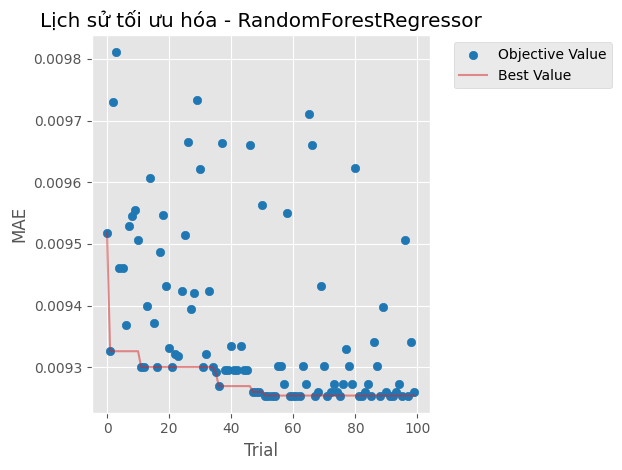

In [52]:
optuna_vis.plot_optimization_history(study)
plt.title("Lịch sử tối ưu hóa - RandomForestRegressor")
plt.xlabel("Trial")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()

In [53]:
def evaluate_model(model, X_test, y_test_original):
    y_pred_log = model.predict(X_test)
    
    # ✅ Đưa cả dự đoán và ground truth về scale gốc
    y_pred = np.expm1(y_pred_log)
    y_test = np.expm1(np.log1p(y_test_original))  # cẩn thận nếu test chưa log — xử lý an toàn

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mean_target = y_test.mean()
    
    print("📊 Đánh giá mô hình:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Mean target: {mean_target:.4f}")
    print(f"MAE / mean target: {mae / mean_target:.2%}")
    
    return y_pred


In [54]:
# === Dữ liệu test ===
X_test = test_df[selected_features]
y_test = test_df['EngagementRateOnPRPost_target']  # giữ nguyên scale gốc
y_pred_test = evaluate_model(rf_model_optuna_v2, X_test, y_test)

📊 Đánh giá mô hình:
RMSE: 0.0446
R²: -0.0445
MAE: 0.0156
Mean target: 0.0251
MAE / mean target: 62.37%


## ExtraTreesRegressor

In [55]:
# ========= Dữ liệu =========
X_train = train_local_df[selected_features]
y_train = np.log1p(train_local_df['EngagementRateOnPRPost_target'])  # ✅ log-transform
X_val = dev_df[selected_features]
y_val = np.log1p(dev_df['EngagementRateOnPRPost_target'])            # ✅ log-transform

# ========= Tối ưu với Optuna =========
def objective_et(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 8),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42,
        'n_jobs': -1
    }

    et_model = ExtraTreesRegressor(**params)
    et_model.fit(X_train, y_train)

    # Dự đoán và đảo log
    y_pred_log = et_model.predict(X_val)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_val)

    mae = mean_absolute_error(y_true, y_pred)
    return mae

# ========= Tối ưu Optuna =========
study_et = optuna.create_study(direction='minimize', study_name="ExtraTrees_MAE_v2")
study_et.optimize(objective_et, n_trials=100)

# ========= Kết quả =========
et_best_params_v2 = study_et.best_trial.params
print("✅ Best params (ExtraTrees v2):", et_best_params_v2)

# ========= Huấn luyện lại trên toàn bộ train_full_df =========
X_full = train_full_df[selected_features]
y_full = np.log1p(train_full_df['EngagementRateOnPRPost_target'])  # ✅ log-transform toàn bộ

et_model_optuna_v2 = ExtraTreesRegressor(**et_best_params_v2)
et_model_optuna_v2.fit(X_full, y_full)

# ========= Lưu lại =========
os.makedirs("model_version_2", exist_ok=True)
model_path = "./model_version_2/et_model_optuna_v2.pkl"
joblib.dump(et_model_optuna_v2, model_path)
print(f"✅ Đã lưu mô hình tại {model_path}")

[I 2025-06-27 19:23:03,563] A new study created in memory with name: ExtraTrees_MAE_v2
[I 2025-06-27 19:23:03,997] Trial 0 finished with value: 0.009963088592218882 and parameters: {'n_estimators': 250, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.009963088592218882.
[I 2025-06-27 19:23:04,341] Trial 1 finished with value: 0.010073810820576196 and parameters: {'n_estimators': 150, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.009963088592218882.
[I 2025-06-27 19:23:04,472] Trial 2 finished with value: 0.010136182855369928 and parameters: {'n_estimators': 50, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.009963088592218882.
[I 2025-06-27 19:23:04,747] Trial 3 finished with value: 0.010248126690747386 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split'

✅ Best params (ExtraTrees v2): {'n_estimators': 300, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
✅ Đã lưu mô hình tại ./model_version_2/et_model_optuna_v2.pkl


/var/folders/f4/d5mj2tt90077gj15fqf69fmw0000gn/T/ipykernel_3581/1461476788.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_optimization_history(study_et)


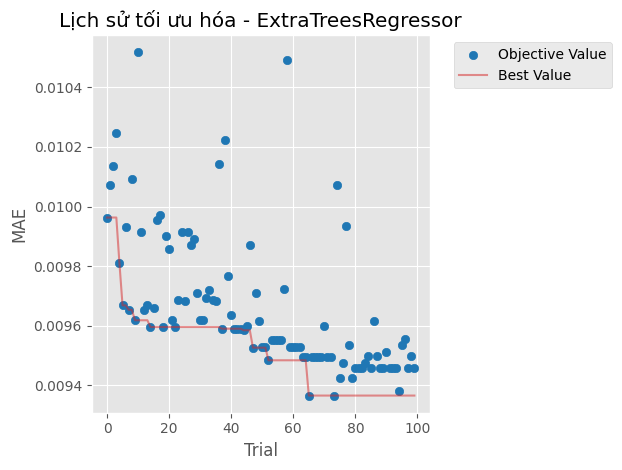

In [56]:
optuna_vis.plot_optimization_history(study_et)
plt.title("Lịch sử tối ưu hóa - ExtraTreesRegressor")
plt.xlabel("Trial")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()

In [57]:
# === Dữ liệu test ===
X_test = test_df[selected_features]
y_test = test_df['EngagementRateOnPRPost_target']  # giữ nguyên scale gốc
y_pred_test = evaluate_model(et_model_optuna_v2, X_test, y_test)

📊 Đánh giá mô hình:
RMSE: 0.0441
R²: -0.0218
MAE: 0.0154
Mean target: 0.0251
MAE / mean target: 61.23%


## HistGradientBoostingRegressor

In [58]:
# ========= Dữ liệu =========
X_train = train_local_df[selected_features]
y_train = np.log1p(train_local_df['EngagementRateOnPRPost_target'])  # ✅ log-transform
X_val = dev_df[selected_features]
y_val = np.log1p(dev_df['EngagementRateOnPRPost_target'])            # ✅ log-transform

# ========= Tối ưu với Optuna (theo MAE) =========
def objective_hgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08),  # nhỏ để tránh overfit sớm
        'max_iter': trial.suggest_int('max_iter', 100, 500, step=50),       # giảm vòng lặp vì tập nhỏ
        'max_depth': trial.suggest_int('max_depth', 3, 10),                 # tránh quá phức tạp
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 40),  # tránh quá khớp
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-3, 1.0, log=True),  # ổn hơn với log-space
        'early_stopping': False,
        'random_state': 42
    }

    hgb_model = HistGradientBoostingRegressor(**params)
    hgb_model.fit(X_train, y_train)

    y_pred_log = hgb_model.predict(X_val)
    y_pred = np.expm1(y_pred_log)  # ✅ inverse transform
    y_true = np.expm1(y_val)

    mae = mean_absolute_error(y_true, y_pred)
    return mae

# ========= Thực hiện tối ưu =========
study_hgb = optuna.create_study(direction='minimize')
study_hgb.optimize(objective_hgb, n_trials=100)

# ========= Kết quả =========
hgb_best_params_v2 = study_hgb.best_trial.params
print("✅ Best params (HistGradientBoosting, MAE):", hgb_best_params_v2)

# ========= Huấn luyện lại trên toàn bộ train_full_df =========
X_full = train_full_df[selected_features]
y_full = np.log1p(train_full_df['EngagementRateOnPRPost_target'])  # ✅ log-transform toàn bộ

hgb_model_optuna_v2 = HistGradientBoostingRegressor(**hgb_best_params_v2)
hgb_model_optuna_v2.fit(X_full, y_full)

# ========= Lưu lại =========
os.makedirs("model_version_2", exist_ok=True)
model_path = "./model_version_2/hgb_model_optuna_v2.pkl"
joblib.dump(hgb_model_optuna_v2, model_path)
print(f"✅ Đã lưu mô hình tại {model_path}")


[I 2025-06-27 19:29:09,194] A new study created in memory with name: no-name-78da719f-b697-47d7-8504-145528fb7db6
[I 2025-06-27 19:29:10,007] Trial 0 finished with value: 0.01003193935541161 and parameters: {'learning_rate': 0.03416860340387437, 'max_iter': 450, 'max_depth': 7, 'min_samples_leaf': 30, 'l2_regularization': 0.0015030218697793033}. Best is trial 0 with value: 0.01003193935541161.
[I 2025-06-27 19:29:10,460] Trial 1 finished with value: 0.010194070234288574 and parameters: {'learning_rate': 0.05876095969321598, 'max_iter': 450, 'max_depth': 6, 'min_samples_leaf': 12, 'l2_regularization': 0.2707892688690944}. Best is trial 0 with value: 0.01003193935541161.
[I 2025-06-27 19:29:10,695] Trial 2 finished with value: 0.009697638963808052 and parameters: {'learning_rate': 0.06909138703863277, 'max_iter': 200, 'max_depth': 8, 'min_samples_leaf': 10, 'l2_regularization': 0.1375220551593463}. Best is trial 2 with value: 0.009697638963808052.
[I 2025-06-27 19:29:10,877] Trial 3 fini

✅ Best params (HistGradientBoosting, MAE): {'learning_rate': 0.03171395533725621, 'max_iter': 200, 'max_depth': 7, 'min_samples_leaf': 20, 'l2_regularization': 0.05233358766691134}
✅ Đã lưu mô hình tại ./model_version_2/hgb_model_optuna_v2.pkl


/var/folders/f4/d5mj2tt90077gj15fqf69fmw0000gn/T/ipykernel_3581/2385155828.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_optimization_history(study_hgb)


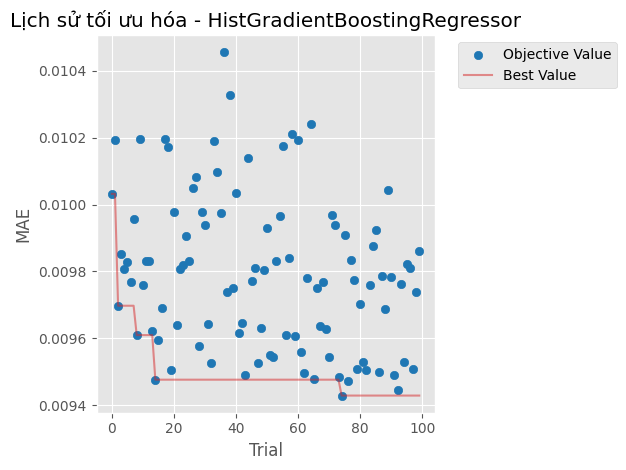

In [59]:
optuna_vis.plot_optimization_history(study_hgb)
plt.title("Lịch sử tối ưu hóa - HistGradientBoostingRegressor")
plt.xlabel("Trial")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()

In [60]:
# === Dữ liệu test ===
X_test = test_df[selected_features]
y_test = test_df['EngagementRateOnPRPost_target']  # giữ nguyên scale gốc
y_pred_test = evaluate_model(hgb_model_optuna_v2, X_test, y_test)

📊 Đánh giá mô hình:
RMSE: 0.0445
R²: -0.0422
MAE: 0.0162
Mean target: 0.0251
MAE / mean target: 64.49%


## XGboost

In [61]:
# ========= Dữ liệu =========
X_train = train_local_df[selected_features]
y_train = np.log1p(train_local_df['EngagementRateOnPRPost_target'])  # ✅ log-transform
X_val = dev_df[selected_features]
y_val = np.log1p(dev_df['EngagementRateOnPRPost_target'])            # ✅ log-transform

# ========= Tối ưu với Optuna (theo MAE) =========
def objective_xgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),               # ✅ nhỏ để tránh overfit
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),           # ✅ phù hợp với size
        'max_depth': trial.suggest_int('max_depth', 3, 10),                              # ✅ tránh quá khớp
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 3),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist',
        'objective': 'reg:squarederror'
    }

    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train, y_train)

    y_pred_log = xgb_model.predict(X_val)
    y_pred = np.expm1(y_pred_log)  # ✅ inverse transform
    y_true = np.expm1(y_val)

    mae = mean_absolute_error(y_true, y_pred)
    return mae

# ========= Thực hiện tối ưu =========
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=100)

# ========= Kết quả =========
xgb_best_params_v2 = study_xgb.best_trial.params
print("✅ Best params (XGBoost, MAE):", xgb_best_params_v2)

# ========= Huấn luyện lại trên toàn bộ train_full_df =========
X_full = train_full_df[selected_features]
y_full = np.log1p(train_full_df['EngagementRateOnPRPost_target'])  # ✅ log-transform

xgb_model_optuna_v2 = xgb.XGBRegressor(**xgb_best_params_v2)
xgb_model_optuna_v2.fit(X_full, y_full)

# ========= Lưu lại =========
os.makedirs("model_version_2", exist_ok=True)
model_path = "./model_version_2/xgb_model_optuna_v2.pkl"
joblib.dump(xgb_model_optuna_v2, model_path)
print(f"✅ Đã lưu mô hình tại {model_path}")


[I 2025-06-27 19:32:25,264] A new study created in memory with name: no-name-46353659-9c2b-4d54-a269-8f3392570b04
[I 2025-06-27 19:32:25,456] Trial 0 finished with value: 0.011433752824290435 and parameters: {'learning_rate': 0.04261447696564794, 'n_estimators': 200, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.702971107351632, 'colsample_bytree': 0.8813126233893513, 'gamma': 1.2285485079550127, 'reg_alpha': 0.08037228334432311, 'reg_lambda': 0.003387953876994875}. Best is trial 0 with value: 0.011433752824290435.
[I 2025-06-27 19:32:26,009] Trial 1 finished with value: 0.011438225462786066 and parameters: {'learning_rate': 0.06620278121043972, 'n_estimators': 400, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.7630138984493797, 'colsample_bytree': 0.7442140121737354, 'gamma': 0.845068889838013, 'reg_alpha': 0.9449504276687457, 'reg_lambda': 0.07071371995595536}. Best is trial 0 with value: 0.011433752824290435.
[I 2025-06-27 19:32:26,251] Trial 2 finished with value: 0

✅ Best params (XGBoost, MAE): {'learning_rate': 0.09694175484288581, 'n_estimators': 250, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.756404458404174, 'colsample_bytree': 0.7812670237077782, 'gamma': 1.537078014340373, 'reg_alpha': 0.013660496312705455, 'reg_lambda': 0.0018200352176343817}
✅ Đã lưu mô hình tại ./model_version_2/xgb_model_optuna_v2.pkl


/var/folders/f4/d5mj2tt90077gj15fqf69fmw0000gn/T/ipykernel_3581/356618700.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_optimization_history(study_xgb)


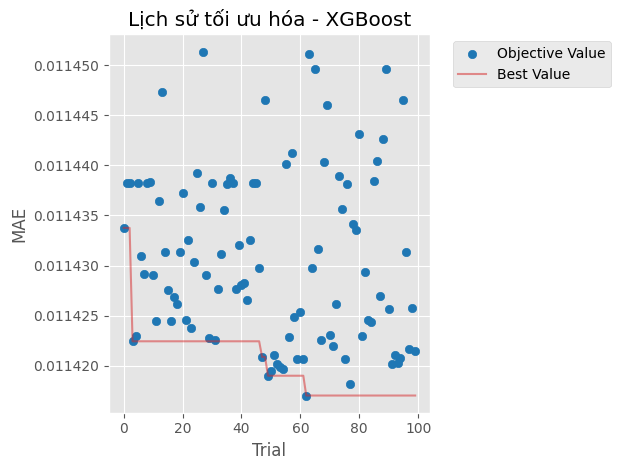

In [62]:
optuna_vis.plot_optimization_history(study_xgb)
plt.title("Lịch sử tối ưu hóa - XGBoost")
plt.xlabel("Trial")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()

In [63]:
# === Dữ liệu test ===
X_test = test_df[selected_features]
y_test = test_df['EngagementRateOnPRPost_target']  # giữ nguyên scale gốc
y_pred_test = evaluate_model(xgb_model_optuna_v2, X_test, y_test)

📊 Đánh giá mô hình:
RMSE: 0.0442
R²: -0.0251
MAE: 0.0167
Mean target: 0.0251
MAE / mean target: 66.78%


## LightGBM

In [64]:
# ========= Dữ liệu =========
X_train = train_local_df[selected_features]
y_train = np.log1p(train_local_df['EngagementRateOnPRPost_target'])  # ✅ log-transform
X_val = dev_df[selected_features]
y_val = np.log1p(dev_df['EngagementRateOnPRPost_target'])    
# ========= Tối ưu với Optuna (theo MAE) =========
def objective_lgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08),  # ✅ nhỏ để ổn định
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }

    lgb_model = LGBMRegressor(**params)
    lgb_model.fit(X_train, y_train)

    y_pred_log = lgb_model.predict(X_val)
    y_pred = np.expm1(y_pred_log)  # ✅ inverse-log
    y_true = np.expm1(y_val)

    mae = mean_absolute_error(y_true, y_pred)
    return mae

# ========= Tối ưu hóa =========
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=100)

# ========= Kết quả =========
lgb_best_params_v2 = study_lgb.best_trial.params
print("✅ Best params (LightGBM, MAE):", lgb_best_params_v2)

# ========= Huấn luyện lại trên toàn bộ train_full_df =========
X_full = train_full_df[selected_features]
y_full = np.log1p(train_full_df['EngagementRateOnPRPost_target'])  # ✅ log-transform

lgb_model_optuna_v2 = LGBMRegressor(**lgb_best_params_v2)
lgb_model_optuna_v2.fit(X_full, y_full)

# ========= Lưu lại =========
os.makedirs("model_version_2", exist_ok=True)
model_path = "./model_version_2/lgb_model_optuna_v2.pkl"
joblib.dump(lgb_model_optuna_v2, model_path)
print(f"✅ Đã lưu mô hình tại {model_path}")


[I 2025-06-27 19:44:28,842] A new study created in memory with name: no-name-8b74ee00-26a5-4e02-a047-962a1f6f983a
[I 2025-06-27 19:44:29,019] Trial 0 finished with value: 0.011438225555472073 and parameters: {'learning_rate': 0.04454274762195661, 'n_estimators': 300, 'max_depth': 6, 'num_leaves': 61, 'min_child_samples': 61, 'subsample': 0.7244440672694127, 'colsample_bytree': 0.9718459483966443, 'reg_alpha': 0.001014205465601248, 'reg_lambda': 0.0018214661017487027}. Best is trial 0 with value: 0.011438225555472073.
[I 2025-06-27 19:44:29,137] Trial 1 finished with value: 0.011438225555472073 and parameters: {'learning_rate': 0.07996141173636179, 'n_estimators': 400, 'max_depth': 4, 'num_leaves': 27, 'min_child_samples': 84, 'subsample': 0.7664280981748907, 'colsample_bytree': 0.9798384516640022, 'reg_alpha': 0.01045553178237191, 'reg_lambda': 0.001898102651684332}. Best is trial 0 with value: 0.011438225555472073.
[I 2025-06-27 19:44:29,208] Trial 2 finished with value: 0.01143822555

✅ Best params (LightGBM, MAE): {'learning_rate': 0.03873777622031395, 'n_estimators': 300, 'max_depth': 8, 'num_leaves': 24, 'min_child_samples': 20, 'subsample': 0.9603262155031814, 'colsample_bytree': 0.9557849709941243, 'reg_alpha': 0.020825345702243682, 'reg_lambda': 0.0037978958731427286}
✅ Đã lưu mô hình tại ./model_version_2/lgb_model_optuna_v2.pkl


/var/folders/f4/d5mj2tt90077gj15fqf69fmw0000gn/T/ipykernel_3581/3061737565.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_optimization_history(study_lgb)


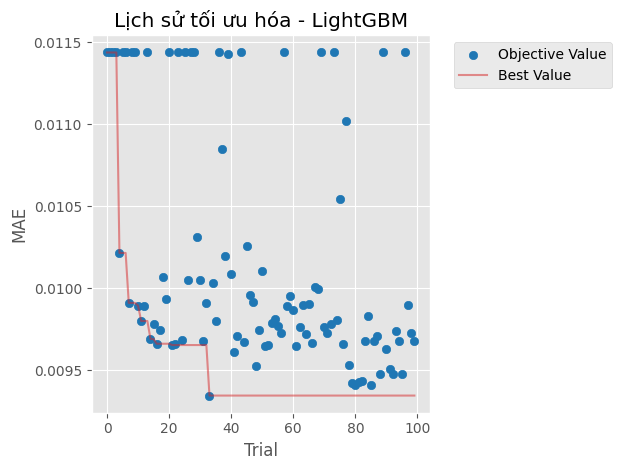

In [65]:
optuna_vis.plot_optimization_history(study_lgb)
plt.title("Lịch sử tối ưu hóa - LightGBM")
plt.xlabel("Trial")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()

In [66]:
# === Dữ liệu test ===
X_test = test_df[selected_features]
y_test = test_df['EngagementRateOnPRPost_target']  # giữ nguyên scale gốc
y_pred_test = evaluate_model(lgb_model_optuna_v2, X_test, y_test)

📊 Đánh giá mô hình:
RMSE: 0.0447
R²: -0.0504
MAE: 0.0164
Mean target: 0.0251
MAE / mean target: 65.46%


## Catboost

In [67]:
# ========= Dữ liệu =========
X_train = train_local_df[selected_features]
y_train = np.log1p(train_local_df['EngagementRateOnPRPost_target'])  # ✅ log-transform
X_val = dev_df[selected_features]
y_val = np.log1p(dev_df['EngagementRateOnPRPost_target'])            # ✅ log-transform

# ========= Tối ưu với Optuna (theo MAE) =========
def objective_cat(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08),  # ✅ nhỏ để ổn định
        'depth': trial.suggest_int('depth', 3, 8),                          # ✅ tránh overfit
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'iterations': trial.suggest_int('iterations', 200, 600, step=100),  # ✅ hợp lý với tập nhỏ
        'random_strength': trial.suggest_float('random_strength', 0.5, 5.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 128),
        'loss_function': 'MAE',             # ✅ tối ưu trực tiếp theo MAE
        'verbose': 0,
        'random_seed': 42
    }

    cat_model = CatBoostRegressor(**params)
    cat_model.fit(X_train, y_train)

    y_pred_log = cat_model.predict(X_val)
    y_pred = np.expm1(y_pred_log)   # ✅ inverse log
    y_true = np.expm1(y_val)

    mae = mean_absolute_error(y_true, y_pred)
    return mae

# ========= Tối ưu hóa =========
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=100)

# ========= Kết quả =========
cat_best_params_v2 = study_cat.best_trial.params
print("✅ Best params (CatBoost, MAE):", cat_best_params_v2)

# ========= Huấn luyện lại trên toàn bộ train_full_df =========
X_full = train_full_df[selected_features]
y_full = np.log1p(train_full_df['EngagementRateOnPRPost_target'])  # ✅ log-transform

cat_model_optuna_v2 = CatBoostRegressor(**cat_best_params_v2)
cat_model_optuna_v2.fit(X_full, y_full)

# ========= Lưu lại =========
os.makedirs("model_version_2", exist_ok=True)
model_path = "./model_version_2/cat_model_optuna_v2.pkl"
joblib.dump(cat_model_optuna_v2, model_path)
print(f"✅ Đã lưu mô hình tại {model_path}")


[I 2025-06-27 19:47:31,466] A new study created in memory with name: no-name-576dcef6-8a9d-4ae3-81ce-e30b261c1d9e
[I 2025-06-27 19:47:32,067] Trial 0 finished with value: 0.00964743743121535 and parameters: {'learning_rate': 0.03558089460218992, 'depth': 4, 'l2_leaf_reg': 7.0907238403762785, 'iterations': 500, 'random_strength': 4.7266721920930905, 'bagging_temperature': 0.32438843918391413, 'border_count': 71}. Best is trial 0 with value: 0.00964743743121535.
[I 2025-06-27 19:47:32,289] Trial 1 finished with value: 0.009706589756747548 and parameters: {'learning_rate': 0.05122778124521255, 'depth': 3, 'l2_leaf_reg': 1.3800150275921261, 'iterations': 600, 'random_strength': 2.1454015395760258, 'bagging_temperature': 0.009763967358199066, 'border_count': 96}. Best is trial 0 with value: 0.00964743743121535.
[I 2025-06-27 19:47:32,709] Trial 2 finished with value: 0.00929757677410636 and parameters: {'learning_rate': 0.04774111465664265, 'depth': 6, 'l2_leaf_reg': 9.913962452795335, 'ite

✅ Best params (CatBoost, MAE): {'learning_rate': 0.06769548610200044, 'depth': 8, 'l2_leaf_reg': 4.974550435604729, 'iterations': 300, 'random_strength': 0.8362898037870785, 'bagging_temperature': 0.35778437844526223, 'border_count': 69}
0:	learn: 0.0128814	total: 2.73ms	remaining: 815ms
1:	learn: 0.0126585	total: 4ms	remaining: 597ms
2:	learn: 0.0124159	total: 5.3ms	remaining: 525ms
3:	learn: 0.0121915	total: 8.02ms	remaining: 593ms
4:	learn: 0.0119498	total: 10.2ms	remaining: 601ms
5:	learn: 0.0117444	total: 12.1ms	remaining: 591ms
6:	learn: 0.0115403	total: 15ms	remaining: 629ms
7:	learn: 0.0113037	total: 18.5ms	remaining: 676ms
8:	learn: 0.0111100	total: 21ms	remaining: 680ms
9:	learn: 0.0108771	total: 22.5ms	remaining: 653ms
10:	learn: 0.0106766	total: 23.8ms	remaining: 625ms
11:	learn: 0.0104836	total: 25ms	remaining: 601ms
12:	learn: 0.0103352	total: 26.3ms	remaining: 580ms
13:	learn: 0.0101499	total: 27.6ms	remaining: 564ms
14:	learn: 0.0099753	total: 29.9ms	remaining: 569ms
15

/var/folders/f4/d5mj2tt90077gj15fqf69fmw0000gn/T/ipykernel_3581/3031092587.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_optimization_history(study_cat)


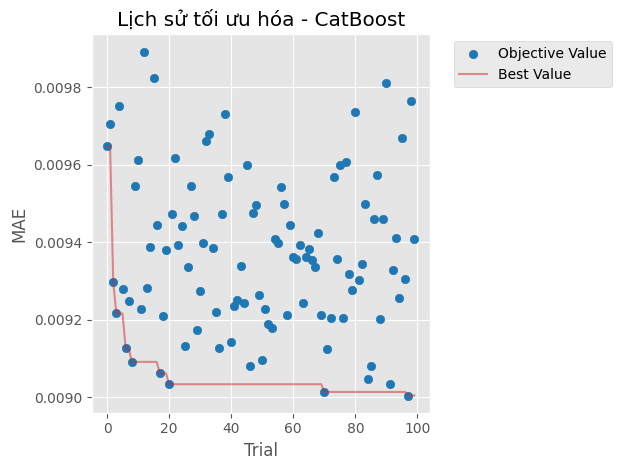

In [68]:
optuna_vis.plot_optimization_history(study_cat)
plt.title("Lịch sử tối ưu hóa - CatBoost")
plt.xlabel("Trial")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()

In [69]:
# === Dữ liệu test ===
X_test = test_df[selected_features]
y_test = test_df['EngagementRateOnPRPost_target']  # giữ nguyên scale gốc
y_pred_test = evaluate_model(cat_model_optuna_v2, X_test, y_test)

📊 Đánh giá mô hình:
RMSE: 0.0442
R²: -0.0258
MAE: 0.0153
Mean target: 0.0251
MAE / mean target: 61.07%


---

# Linear Model

In [83]:
def save_model(model, filename, folder="model_version_2"):
    os.makedirs(folder, exist_ok=True)
    model_path = os.path.join(folder, filename)
    joblib.dump(model, model_path)
    print(f"✅ Đã lưu mô hình tại {model_path}")

## Linear Regression

In [ ]:
drop_columns = ["vietnam_follower"]

X_train = train_local_df[selected_features].drop(columns=drop_columns, errors="ignore")
X_val = dev_df[selected_features].drop(columns=drop_columns, errors="ignore")
X_full = train_full_df[selected_features].drop(columns=drop_columns, errors="ignore")
X_test = test_df[selected_features].drop(columns=drop_columns, errors="ignore")

# Giữ nguyên cột cho các bộ
common_cols = X_train.columns
X_val = X_val[common_cols]
X_full = X_full[common_cols]
X_test = X_test[common_cols]

y_train = np.log1p(train_local_df['EngagementRateOnPRPost_target'])
y_val = np.log1p(dev_df['EngagementRateOnPRPost_target'])
y_full = np.log1p(train_full_df['EngagementRateOnPRPost_target'])
y_test_original = test_df['EngagementRateOnPRPost_target']

# ==== Pipeline: StandardScaler + PCA + Linear Regression ====
pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),  # giữ 95% phương sai
    ("lr", LinearRegression())
])

pipeline_lr.fit(X_train, y_train)

print("🔹 Linear Regression")
_ = evaluate_model(pipeline_lr, X_test, y_test_original)  # dùng test_df gốc


🔹 Linear Regression
📊 Đánh giá mô hình:
RMSE: 0.0459
R²: -0.1060
MAE: 0.0179
Mean target: 0.0251
MAE / mean target: 71.39%


## Ridge

In [84]:
def objective_ridge(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 10.0, log=True)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("ridge", Ridge(alpha=alpha))
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    return mean_absolute_error(np.expm1(y_val), np.expm1(y_pred))

study_ridge = optuna.create_study(direction='minimize')
study_ridge.optimize(objective_ridge, n_trials=50)

best_alpha_ridge = study_ridge.best_params['alpha']
pipeline_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("ridge", Ridge(alpha=best_alpha_ridge))
])
pipeline_ridge.fit(X_full, y_full)

save_model(pipeline_ridge, "ridge_model_optuna.pkl")

print("🔹 Ridge Regression")
_ = evaluate_model(pipeline_ridge, X_test, y_test_original)

[I 2025-06-27 21:08:42,011] A new study created in memory with name: no-name-2080512d-6f68-45b5-b0be-a1b46f0cd89a
[I 2025-06-27 21:08:42,139] Trial 0 finished with value: 0.011138316819050566 and parameters: {'alpha': 0.0011464716768947517}. Best is trial 0 with value: 0.011138316819050566.
[I 2025-06-27 21:08:42,152] Trial 1 finished with value: 0.011137830172733058 and parameters: {'alpha': 0.026698964217652027}. Best is trial 1 with value: 0.011137830172733058.
[I 2025-06-27 21:08:42,164] Trial 2 finished with value: 0.011120060084808247 and parameters: {'alpha': 1.0380033762790115}. Best is trial 2 with value: 0.011120060084808247.
[I 2025-06-27 21:08:42,176] Trial 3 finished with value: 0.011125846559526824 and parameters: {'alpha': 0.693182839752912}. Best is trial 2 with value: 0.011120060084808247.
[I 2025-06-27 21:08:42,194] Trial 4 finished with value: 0.011136968186200493 and parameters: {'alpha': 0.07204792397630891}. Best is trial 2 with value: 0.011120060084808247.
[I 202

✅ Đã lưu mô hình tại model_version_2/ridge_model_optuna.pkl
🔹 Ridge Regression
📊 Đánh giá mô hình:
RMSE: 0.0443
R²: -0.0312
MAE: 0.0173
Mean target: 0.0251
MAE / mean target: 68.79%


## Lasso Regression

In [85]:
def objective_lasso(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1.0, log=True)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("lasso", Lasso(alpha=alpha, max_iter=10000))
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    return mean_absolute_error(np.expm1(y_val), np.expm1(y_pred))

study_lasso = optuna.create_study(direction='minimize')
study_lasso.optimize(objective_lasso, n_trials=50)

best_alpha_lasso = study_lasso.best_params['alpha']
pipeline_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("lasso", Lasso(alpha=best_alpha_lasso, max_iter=10000))
])
pipeline_lasso.fit(X_full, y_full)

save_model(pipeline_ridge, "lasso_model_optuna.pkl")

print("🔹 Lasso Regression")
_ = evaluate_model(pipeline_lasso, X_test, y_test_original)


[I 2025-06-27 21:12:02,304] A new study created in memory with name: no-name-bf77a61c-3801-40b1-9fcf-2d41fcd2a7e3
[I 2025-06-27 21:12:02,357] Trial 0 finished with value: 0.010871456822216527 and parameters: {'alpha': 0.0013581598885372432}. Best is trial 0 with value: 0.010871456822216527.
[I 2025-06-27 21:12:02,378] Trial 1 finished with value: 0.010915557885069567 and parameters: {'alpha': 0.0017896603230348924}. Best is trial 0 with value: 0.010871456822216527.
[I 2025-06-27 21:12:02,514] Trial 2 finished with value: 0.011438225561189218 and parameters: {'alpha': 0.3036360379573432}. Best is trial 0 with value: 0.010871456822216527.
[I 2025-06-27 21:12:02,543] Trial 3 finished with value: 0.011438225561189218 and parameters: {'alpha': 0.009696658603656398}. Best is trial 0 with value: 0.010871456822216527.
[I 2025-06-27 21:12:02,558] Trial 4 finished with value: 0.010974722622088406 and parameters: {'alpha': 0.0002673887123560987}. Best is trial 0 with value: 0.010871456822216527.


✅ Đã lưu mô hình tại model_version_2/lasso_model_optuna.pkl
🔹 Lasso Regression
📊 Đánh giá mô hình:
RMSE: 0.0438
R²: -0.0095
MAE: 0.0176
Mean target: 0.0251
MAE / mean target: 70.03%


## SVR

In [86]:
def objective_svr(trial):
    C = trial.suggest_float("C", 0.1, 100.0, log=True)
    epsilon = trial.suggest_float("epsilon", 1e-4, 0.1, log=True)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("svr", SVR(kernel='rbf', C=C, epsilon=epsilon))
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    return mean_absolute_error(np.expm1(y_val), np.expm1(y_pred))

study_svr = optuna.create_study(direction='minimize')
study_svr.optimize(objective_svr, n_trials=50)

best_params_svr = study_svr.best_params
pipeline_svr = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("svr", SVR(kernel='rbf', C=best_params_svr["C"], epsilon=best_params_svr["epsilon"]))
])
pipeline_svr.fit(X_full, y_full)

save_model(pipeline_ridge, "svr_model_optuna.pkl")

print("🔹 SVR")
_ = evaluate_model(pipeline_svr, X_test, y_test_original)

[I 2025-06-27 21:14:16,798] A new study created in memory with name: no-name-9acffa4d-8d6e-4317-b8f1-76d933857d6d
[I 2025-06-27 21:14:16,910] Trial 0 finished with value: 0.011253289434024831 and parameters: {'C': 22.66650574335454, 'epsilon': 0.00925914158124501}. Best is trial 0 with value: 0.011253289434024831.
[I 2025-06-27 21:14:16,937] Trial 1 finished with value: 0.015612168963563258 and parameters: {'C': 61.86196406075822, 'epsilon': 0.024367338039030982}. Best is trial 0 with value: 0.011253289434024831.
[I 2025-06-27 21:14:16,950] Trial 2 finished with value: 0.01645147055787503 and parameters: {'C': 0.22181258003670162, 'epsilon': 0.07481945104220321}. Best is trial 0 with value: 0.011253289434024831.
[I 2025-06-27 21:14:16,961] Trial 3 finished with value: 0.01645147055787503 and parameters: {'C': 0.24471587428785802, 'epsilon': 0.055864630188093935}. Best is trial 0 with value: 0.011253289434024831.
[I 2025-06-27 21:14:16,984] Trial 4 finished with value: 0.012321355722022

✅ Đã lưu mô hình tại model_version_2/svr_model_optuna.pkl
🔹 SVR
📊 Đánh giá mô hình:
RMSE: 0.0443
R²: -0.0295
MAE: 0.0250
Mean target: 0.0251
MAE / mean target: 99.77%
